---

# IMPORTING LYBRARIES

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time, itertools, dataframe_image as dfi, os
from datetime import datetime
from IPython.display import clear_output

import seaborn as sns; sns.set_style('darkgrid')
import pandas as pd; pd.set_option('display.max_colwidth', None) 
import warnings; warnings.filterwarnings('ignore')

from sklearn.utils import all_estimators # Machine Learning Estimators
from sklearn.preprocessing import LabelEncoder as le, MinMaxScaler as mms, StandardScaler as ss
from sklearn.linear_model import LinearRegression as lr
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit as sss, train_test_split
from sklearn.metrics import (accuracy_score as acc_scr, r2_score, classification_report,
                            confusion_matrix, make_scorer, matthews_corrcoef, precision_score,
                            recall_score, f1_score, fbeta_score, precision_recall_fscore_support)
import joblib

---

# FUNCTIONS

#### Encode dataframe columns to Label, Ordinal, Float, String, Integer or Onehot type.

encode(df_copy, test_set=None, ordinal_cols=None, label_cols=None, float_cols=None, string_cols=None, int_cols=None, onehot_cols=None, concat_onehot=False, prefix_col=''):

In [2]:
def encode(df_copy, test_set=None, ordinal_cols=None, label_cols=None, float_cols=None, string_cols=None, int_cols=None, onehot_cols=None, concat_onehot=False, prefix_col=''):
    
    if type(test_set)==type(None): dfs = [df_copy.copy()]
    else: dfs = [df_copy.copy(), test_set.copy()]
    
    new_dfs = []
    for df in dfs.copy():

        if type(ordinal_cols)!=type(None):
            n_ordinals = len(ordinal_cols)
            for i, col in enumerate(ordinal_cols):
                ord_encoded_col = df[col].to_frame()
                df[col] = oe().fit(ord_encoded_col).transform(ord_encoded_col)
                clear_output(wait=True)
                print('Rotulando Variáveis Ordinais... - ', i, '/', n_ordinals)

        if type(label_cols)!=type(None):
            n_labels = len(label_cols)
            for i, col in enumerate(label_cols):

                label_encoded_col = df[col]
                df[col] = le().fit(label_encoded_col).transform(label_encoded_col)
                clear_output(wait=True)
                print('Rotulando Variáveis Categóricas... - ', i, '/', n_labels)

        if type(float_cols)!=type(None):
            n_floats = len(float_cols)
            for i, col in enumerate(float_cols):

                df[col] = df[col].astype(float)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "Float"... - ', i, '/', n_floats)

        if type(string_cols)!=type(None):         
            n_strings = len(string_cols)
            for i, col in enumerate(string_cols):

                df[col] = df[col].astype(str)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "String"... - ', i, '/', n_strings)

        if type(int_cols)!=type(None):         
            n_int = len(int_cols)
            for i, col in enumerate(int_cols):

                df[col] = df[col].astype(int)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "String"... - ', i, '/', n_int)

        if type(onehot_cols)!=type(None):         
            n_onehot = len(onehot_cols)
            onehot_lst = []
            for i, col in enumerate(onehot_cols):
                onehot_lst.append(pd.get_dummies(df[col], prefix=col+prefix_col))
                clear_output(wait=True)
                print('OneHot Encoding Variáveis... - ', i, '/', n_onehot)

            print('Concatenando Variáveis Onehot...')
            onehot_df = pd.concat(onehot_lst, axis=1)

            if concat_onehot: 
                print('Concatenando Dataframe OneHot...')
                df = pd.concat([df, onehot_df])
            else: 
                df = pd.concat([df.drop(onehot_cols, axis=1), onehot_df], axis=1)

        new_dfs.append(df.copy())
    
    if type(onehot_cols)!=type(None):
        if type(test_set)!=type(None):          
            keep_cols = list(set(new_dfs[0].columns).intersection(new_dfs[1].columns))
            new_dfs = [new_df[keep_cols] for new_df in new_dfs]
            
    return new_dfs

---

#### Filter a dataframe by the specified classes of one of its columns and/or replace classes labels.

filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False)

In [3]:
def filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False):
    
    print('Construindo Index...')       # Selecionando index onde alvo em 'ctgr_lst'
    new_index=[]
    for ctgr in ctgr_lst:
        new_index += df[df[target]==ctgr].index.tolist()
    
    print('Extraindo Dados da Tabela...')      # Extraindo tabela com index construído
    df = df.loc[new_index]    
    
    if type(replace_dict)!=type(None):
        print('Substituindo Categorias: {}'.format(replace_dict))      # Fusão de categorias
        for key in replace_dict.keys():
            df[target] = df[target].replace(key, replace_dict[key])
    
    if encode:
        print('Rotulando Variável Alvo...')
        df[target] = le().fit(df[target]).transform(df[target])      # Rotulando variável alvo
        
    print('\nCategorias Atualizadas!')
    return df

---

#### Train and score multiple models at once by Inputting a list with the models  given the training and testing datasets.

scr_models(train_set, test_set=None, target='TX_RESP_Q050', models=None,
               names=None, params_list=None,
               method='classes', keep_params=False,
               clear=True, score_fbeta=False, betas=list(np.linspace(0,1,10)), triple=False)

In [4]:
def scr_models(train_set, test_set=None, target='TX_RESP_Q050', models=None,
               names=None, params_list=None,
               method='classes', keep_params=False,
               clear=True, score_fbeta=False, betas=list(np.linspace(0,1,10)), triple=False):
    
    n_models=len(models)
    if type(params_list)==type(None): params_list = [{}]*n_models

    rows = []
    cnt=1
    for model, name, params in zip(models, names, params_list):

        if clear: clear_output(wait=True)
        print('\nAvaliando Modelo {} - ({}/{})'.format(name, cnt, n_models))
        
        if triple:
                
            row = scr_triple(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        else:
        
            row = scr(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        
        rows.append(row)
        cnt+=1

    scrs_df = pd.concat(rows, axis=1).T
    if keep_params: 
        params_df = pd.DataFrame(params)
        scrs_df = pd.concat([scrs_df, params_df], axis=1)
        
    return scrs_df

---

#### Train and Score a model given the model and the training and testing datasets

scr(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={},
    method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10)), verbose=1)

In [5]:
def scr(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10)), verbose=1, model_path=None):

    if verbose>=2: print('\nExtraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    else:
        if verbose >= 1: print('\nConstruindo Modelo {}...'.format(name))
        new_model = model(**params)
        if verbose >= 1: print('Fitting...')
        new_model.fit(x_train, y_train)
        
        if verbose >= 1: print('Predicting...')
        y_pred = new_model.predict(x_test)
        if verbose >= 1: print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
    
    return scrs
    

def scr_triple(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10))):

    print('Extraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - 2',
             'recall - 2',
             'f1-score - 2',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    elif method=='classes':
        print('Construindo Modelo {}...'.format(name))
        new_model = model(**params)
        print('Fitting...')
        new_model.fit(x_train, y_train)
        print('Predicting...')
        y_pred = new_model.predict(x_test)
        print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['2'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
        
    return scrs
    

---

#### Training classification models and returning their feature importances given a dataset and the target variable name.

feat_imp(df, target, test_size=0.2, random_state=None, n_models=1)

In [6]:
def feat_imp(df, target, test_size=0.2, random_state=None, n_models=1):

    feat_imp_models = [TREE, RFC, ETC, GBC, ABC][:n_models]
    feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC'][:n_models]
    
    y = df[target].copy()
    x = df.drop([target], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1-test_size), random_state=random_state)

    feat_cols = x_train.columns.tolist()
    scrs = []
    lst = []
    for i in range(len(feat_imp_models)):

        print('({}/{}) {}'.format(i, len(feat_imp_names), feat_imp_names[i]))
        print('Fitting...')
        model = feat_imp_models[i]().fit(x_train, y_train)
        print('Predicting...')
        y_pred = model.predict(x_test)
        print('Scoring...')
        acc = acc_scr(y_test, y_pred)

        feat_imps = model.feature_importances_.tolist()
        lst.append([feat_imp_names[i]]+feat_imps)
        scrs.append([feat_imp_names[i], acc])

        clear_output(wait=True)

    scrs_df = pd.DataFrame(scrs, columns=['model_name', 'acc']).set_index('model_name')
    feat_df = pd.DataFrame(lst, columns=['model_name'] + feat_cols).set_index('model_name')

    return scrs_df, feat_df

---

#### Paramter optimization using Grid Search. Input a list of the parameteres as dictionaries. Return scores for the grid.

tune_model(df, target, model, params_dicts, retraining=None, random_state=4, clear=False, cross_val=False)

In [7]:
def tune_model(df, target, model, params_dicts, retraining=None, random_state=4, clear=False, cross_val=False):
        
    params_names = list(params_dicts[0].keys())

    if cross_val: 
        cols = ['scr {}'.format(i) for i in range((cv if type(cv)!=type(None) else 5))]
    else: 
        cols = ['acc']
        
    print('Extraindo variáveis alvo e independentes...')
    y = df[target]
    x = df.drop(target, axis=1)
    print('Dividindo amostras de treinamento e de teste...')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

    etc_scrs = []
    loop_size = len(params_dicts)
    cnt=0
    print('{}/{}'.format(cnt, loop_size))
    for params in params_dicts:
        
        params_values = list(params.values())
        
        print('Fitting...')
        new_model = model(**params)
        new_model.fit(x_train, y_train)
                
        if cross_val:
            print('Cross Validating Model...')
            acc = list(cross_val_score(new_model, x_test, y_test))
            
        else:
            print('Predicting...')
            y_pred = new_model.predict(x_test)
            print('Scoring...')
            acc = [acc_scr(y_test, y_pred)]
        
        
        etc_scrs.append(params_values+acc)

            
        cnt+=1
        if clear: clear_output(wait=True)
        print('{}/{}'.format(cnt, loop_size), params)

    etc_df = pd.DataFrame(etc_scrs, columns=params_names+cols)
    
    if type(retraining)!=type(None):
        etc_df = pd.concat([retraining, etc_df], axis=0)
    return etc_df

---

#### Sample a dataframe into training and testing sets by specifying the count of each class of the binary target variable for both sets. It includes the option to automaticly fill the "1" class members or to equalize the number of members.

binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False)

In [8]:
def binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False, path=None):
    
    if invert:
        training=testing.copy()
        testing=[None, None]
    
    print('Extraindo Index por Categoria...')
    index_0 = df[df[target].isin(categories[0])].index
    index_1 = df[df[target].isin(categories[1])].index
        
    if type(test_set)==type(None):
        return_test=True
        print('Extraindo Index Teste - {} para {}...'.format(testing[0], testing[1]))
        test_index = list(np.random.choice(index_0, testing[0], replace=False)) + list(np.random.choice(index_1, testing[1], replace=False))
        print('Extraindo Tabela de Teste...')
        test_set = df.loc[test_index]
    
    else:
        return_test=False
        test_index = test_set.index.tolist()        
    
    print('Extraindo Index Treinamento (Excluindo Index Teste) - {} para {}...'.format(training[0], training[1]))  
    
    index_1_train = list(set(index_1).difference(test_index))   # Está Invertido (1 depois 0)
    if not fill_train_1: index_1_train = list(np.random.choice(index_1_train, training[1], replace=False))
    
    index_0_train = list(set(index_0).difference(test_index))
    if equal_train_0: training[0] = len(index_1_train)
    index_0_train = list(np.random.choice(index_0_train, training[0], replace=False))
    
    train_index = index_0_train + index_1_train
    
    print('Extraindo Tabela de Treinamento...')
    train_set = df.loc[train_index]    
        
    clear_output(wait=True)
    if print_shapes:
        print('Original Shape:')
        print(ano9_base.shape)
        print('Test Set Shape:')
        print(test_set.shape)
        print('Train Set Shape:')
        print(train_set.shape)
        print('')

    
    sets = [df, train_set, test_set]
    report_cols = ['Original', 'Treinamento', 'Teste']
    
    print('Contagem Abandono:')
    if invert: 
        report_cols[1], report_cols[2] = report_cols[2], report_cols[1]

    relatorio_amostragem = pd.concat([data_set[target]
                                      .value_counts()
                                      .to_frame()
                                      .rename(columns={target:col_name}) for data_set, col_name in zip(sets, report_cols)], axis=1)
    relatorio_amostragem.index=['Regular', 'Abandono']
    display(relatorio_amostragem)
    if type(path)!=type(None): dfi.export(relatorio_amostragem, path)
   
    inter = set(train_set.index).intersection(test_set.index)
    if inter: print('\nInformação Vazada para Tabela de Treinamento')
    else: print('\nNenhum Aluno em Comum nas Tabelas de Treinamento e Teste')

    if not return_test: return train_set
    return train_set, test_set

---

#### Binary Classes Proportion Optimization

size_opt(train_set, test_set, target, models, names, path, params={},
             min0=0.1, max0=1, min1=0.1, max1=1,
             n_cat0=10, n_cat1=10, degree_cat0=3, degree_cat1=2,
             history=[], cats_names=['Não Abandono', 'Abandono'], fbeta=None)

In [9]:
def size_opt(train_set, test_set, target, models, names, path, params={},
             min0=0.1, max0=1, min1=0.1, max1=1,
             n_cat0=10, n_cat1=10, degree_cat0=3, degree_cat1=3,
             history=[], cats_names=['Não Abandono', 'Abandono'], fbeta=None):

    y = train_set[target]
    cat0 = train_set[y==0]
    cat1 = train_set[y==1]
    cat0_index = cat0.index
    cat1_index = cat1.index
    len_cat0 = len(cat0)
    len_cat1 = len(cat1)
    len_train_set = len(train_set)
    
    rnd_gen = np.random.default_rng()
    dt_i = []
    for model, name in zip(models, names):
        
        t0 = datetime.now()
        cat0_loop = [int(i) for i in (np.linspace(min0 , max0, n_cat0)[:]**degree_cat0) * len_cat0 ]  
        cat1_loop = [int(i) for i in (np.linspace(min1, max1, n_cat1)[:]**degree_cat1) * len_cat1 ]

        n_iter = n_cat0 * n_cat1
        cnt = 0
        sizes_lst = []

        for sample_size_cat0 in cat0_loop:
            for sample_size_cat1 in cat1_loop:

                clear_output(wait=True)
                print('Proporção Categorias', '\nX0:', round(sample_size_cat0, 4), 'X1:', round(sample_size_cat1, 4), '-  {}/{}  ({}%)'.format(cnt, n_iter, round(cnt/n_iter*100, 2)))

                print('\nConstruindo index...')                
                sample_index = rnd_gen.choice(cat0_index, sample_size_cat0).tolist() + rnd_gen.choice(cat1_index, sample_size_cat1).tolist()

                print('Retirando Amostra...')
                train_set_sample = train_set.loc[sample_index]

                acc_df = scr(train_set_sample, test_set, target, model, name, params, method='classes')
                acc_df[cats_names[0]], acc_df[cats_names[1]] = sample_size_cat0, sample_size_cat1         
                
                index = acc_df.index
                new_index = index[-2:].tolist() + index[:-2].tolist()
                acc_df = acc_df[new_index]
                
                sizes_lst.append(acc_df)

                cnt+=1
        
        sizes_df = pd.concat(sizes_lst, axis=1).T
        history.append([name, sizes_df])
        sizes_df.to_csv(path.format(name))
        
        dt_i.append([name, datetime.now() - t0])
    
    exe_time = pd.DataFrame(dt_i, columns=['Model', 'Execution Time'])
    return history, exe_time

---

### Visualization Functions

In [10]:
def report_2d(sizes_df, x='p', xlim=(-0.1, 10), ylim=(-0.05),  figsize=(15, 2), outcols=['support', 'support - 0', 'support - 1'],
              scatter=True, marker=None, ms=1, lw=None, path=None):
    
    colors_report = [['blue', 'green'],
                     ['green', 'orange', 'red'],
                     ['green', 'orange', 'red'],
                     ['green', 'orange', 'red']]
    
    cols = pd.Series([col for col in sizes_df.columns[1:] if col not in [x] + outcols])
    fig, axs = plt.subplots(1,4, figsize=figsize)
    
    for i, col_index in enumerate([[1,2], [3,4,5], [6,7,8], [9,10,11]]):
        for col, color in zip(col_index, colors_report[i]):            
            
            if scatter:
                sizes_df.plot.scatter(x=x, y=cols[col], ax=axs[i], color=color)
        
            else:
                sizes_df.sort_values(x).plot(x=x, y=cols[col], ax=axs[i], color=color, marker=marker, ms=ms, lw=lw)
        
        axs[i].set(xlim=xlim, ylim=ylim)
        axs[i].legend(cols[col_index])

    plt.show()
    plt.pause(0.01)
    if type(path)!=type(None): fig.savefig(path, bbox_inches='tight')
       
    
def make_grid(df, columns, verbose=1):

    xo, yo, zo = [df.loc[:, col] for col in columns]

    m, n = len(xo.unique()), len(yo.unique())

    xp = np.array(xo).reshape(m,n)
    yp = np.array(yo).reshape(m,n)
    zp = np.array(zo).reshape(m,n)
    
    if verbose==1:
        print('3D Grid:')
        print(xp.shape, yp.shape, zp.shape)
    
    return xp, yp, zp

def xyz_max(sizes_df, xy, z):
    max_df = sizes_df.groupby([xy[0]]).max()
    x_max = max_df.index
    z_max = max_df[z]
    y_max = sizes_df[sizes_df[z].isin(z_max.tolist())][xy[1]]
    print('2D Arrays:')
    print(x_max.shape, y_max.shape, z_max.shape)
    return  x_max, y_max, z_max

def projections(df, x, y, z, color='blue'):
    
    fig, axs = plt.subplots(1,2,figsize=(16,4))

    df.groupby(y).plot(x, z, ax=axs[0], color=color)
    df.groupby(x).plot(y, z, ax=axs[1], color=color)

    [axs[i].set(ylabel=z) for i in [0,1]]
    [axs[i].legend([]) for i in [0,1]]
    plt.show()

def scatter_3d(xs, ys, zs, rate=10, stop=0, method='simple', figsize=(10,6), alpha=0.7):
    
    for angle in range(0,360+stop,rate):

        fig = plt.figure(figsize=figsize, tight_layout=True)
        axs = fig.add_subplot(1,1,1,projection='3d')

        if method=='trisurf':
            axs.plot_trisurf(xs, ys,zs, alpha=alpha)
        else:
            axs.scatter(xs, ys, zs)
        
        axs.set(xlabel=xs.name, ylabel=ys.name, zlabel=zs.name)
        axs.view_init(8, angle)

        plt.show()
        plt.pause(0.01)
        clear_output(wait=True)

def scatter_2d(sizes_df, x, x_max=20, x_min=-0.5,  figsize=(17, 6), outcols=['support', 'support - 0', 'support - 1']):
    
    cols = [col for col in sizes_df.columns[1:] if col!=x and col not in [x] + outcols]
    fig, axs = plt.subplots(3,4, figsize=figsize)
    
    row, i = 0, 0
    for col in cols:
        if i==4: 
            i, row = 0, row+1

        sizes_df.plot.scatter(x=x, y=col, ax=axs[row][i])
        axs[row][i].set_xlim(-0.5, x_max)
        i+=1
    plt.show()
    plt.pause(0.01)

def plot_3d(xi, yi, zi, angle1=15, angle2=60, method='surface', zdir='z', cmap='coolwarm', norm=False, figsize=(7,4), labels=['X', 'Y', 'Z'], color='blue', alpha=1):
    
    if norm: norm = matplotlib.colors.Normalize()
    else: norm=None
    
    fig = plt.figure(figsize=figsize, tight_layout=True)
    axs = [fig.add_subplot(1,1,j,projection='3d') for j in [1]]

    if method=='surface': axs[0].plot_surface(yi, xi, zi, cmap=cmap, norm=norm, color=color, alpha=alpha)
    if method=='wireframe': axs[0].plot_wireframe(xi, yi, zi, cmap=cmap, color=color, alpha=alpha)
    if method=='contour':  axs[0].contour(xi, yi, zi, stride=1, zdir=zdir, color=color, alpha=alpha)

    [axs[k].view_init(angle1, angle2) for k in [0]]
    [axs[k].set(xlabel=labels[0], ylabel=labels[1], zlabel=labels[2]) for k in range(1)]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)


def plot_3d_ontop(xyz_list, colors_list=None, alpha_list=None, method='surface', zdir='z', angle1=15, angle2=60, cmap=None, norm=False, figsize=(7,4)):
    
    if type(colors_list)==type(None): colors_list=[None]*len(xyz_list)
    if type(alpha_list)==type(None): alpha_list=[1]*len(xyz_list)
    
    if norm: norm = matplotlib.colors.Normalize()
    else: norm = None
    
    fig = plt.figure(figsize=figsize, tight_layout=True)
    axs = [fig.add_subplot(1,1,j,projection='3d') for j in [1]]
    
    for i, (xi, yi, zi) in enumerate(xyz_list):

        if method=='surface': axs[0].plot_surface(yi, xi, zi, color=colors_list[i], alpha=alpha_list[i], cmap=cmap, norm=norm)
        if method=='wireframe': axs[0].plot_wireframe(xi, yi, zi, alpha=0.7, cmap=cmap)
        if method=='contour':  axs[0].contour(xi, yi, zi, alpha=1, stride=1, zdir=zdir)

            
    [axs[k].view_init(angle1, angle2) for k in [0]]
    [axs[k].set(xlabel=xs.name, ylabel=ys.name, zlabel=zs.name) for k in range(1)]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)


def rotate_3d(xyz, on_top=False, steps=(10,10), starts=(0,0), stops=(360,360), method='surface', zdir='z', colors_list=None, alpha_list=None, cmap=None, norm=False, figsize=(7,4), angle_var=7, labels=['X', 'Y', 'Z']):
    
    if not on_top: xi, yi, zi = xyz
    
    for angle1, angle2 in zip(range(starts[0], stops[1], steps[0]), range(starts[0], stops[0], steps[1])):
        
        if on_top: plot_3d_ontop(xyz, method=method, zdir=zdir, angle1=angle1/angle_var, angle2=angle2, colors_list=colors_list, alpha_list=alpha_list, cmap=cmap, norm=norm, figsize=figsize)
        
        else: plot_3d(xi, yi, zi, angle1=angle1/angle_var, angle2=angle2, method=method, zdir=zdir, figsize=figsize, labels=labels)


def full_plot_3d(xi, yi, zi,
                 labels=None, title=None, cmap='coolwarm',
                 method='surface', final_angle=360, figsize=(13,7),
                 tight_layout=False, path=None):

    for angle, angle2 in zip(range(0, final_angle,10), range(0, final_angle, int(10))):

        fig = plt.figure(figsize=figsize, tight_layout=tight_layout)
        axs = [fig.add_subplot(2,2,j,projection='3d') for j in [1,2,3,4]]


        if method=='surface': axs[0].plot_surface(yi, xi, zi, alpha=1, cmap=cmap)

        else: axs[0].plot_wireframe(xi, yi, zi, alpha=0.7, cmap=cmap)

        axs[1].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='x',
                       offset=None)
        axs[2].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='y',
                       offset=None)
        axs[3].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='z',
                       offset=None)

        [axs[k].view_init(angle/7, angle) for k in [0,1,2,3]]
        
        if type(labels)!=type(None): xlabel, ylabel, zlabel = labels
        else: xlabel, ylabel, zlabel = ['X', 'Y', 'Z']
        
        
        [axs[k].set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel, title=title) for k in range(4)]

        clear_output(wait=True)
        plt.show()
        plt.pause(0.001)
        if type(path)!=type(None): fig.savefig(path.format(angle), bbox_inches='tight')

        
        

---

# 1. DATA CLEANING

# 1.1 Loading Student Socioeconomic Questionnarie - Raw Dataset

#### Brasilian Student Socioeconomic Questionnaire - National

In [11]:
data_path = '\\Users\luisr\Desktop\Repository\Repository Data\Data\saep\CSV\{}'

file_name = 'saep_qst_aluno.csv'
qst_raw = pd.read_csv(data_path.format(file_name)).drop('Unnamed: 0', 1)

In [17]:
pd.DataFrame(qst_raw.shape, index=['Rows', 'Columns'], columns=['Count']).T

,Rows,Columns
Count,1048575,77


# 1.2 Loading Adapted Data Dictionaries

In [95]:
dict_filenames = [f'dicionario {i}ano.csv' for i in [5,9,3]]; dict_filenames
dicts = [pd.read_csv(data_path.format(filename)).set_index('questão') for filename in dict_filenames]

### Displaying and Saving datasets' images

#### Questionnaires' answer cheets dataset

In [120]:
data_png = qst_raw.head().iloc[:, :20].set_index('ID_ALUNO').T
dfi.export(data_png, 'Tables/Data Cleaning/Main_Table_Head.png'); data_png

ID_ALUNO,204319,204320,907687,1611630,1611631
ID_SAEB,2011,2011,2011,2011,2011
ID_REGIAO,1,1,1,1,1
ID_UF,11,11,11,11,11
ID_MUNICIPIO,1100015,1100015,1100015,1100015,1100015
ID_ESCOLA,11024682,11024682,11024682,11024682,11024682
ID_DEPENDENCIA_ADM,2,2,2,2,2
ID_LOCALIZACAO,1,1,1,1,1
ID_CAPITAL,2,2,2,2,2
ID_TURMA,52401,52401,52401,52401,52401
ID_TURNO,2,2,2,2,2


#### 9th Grade Dictionary Dataset

In [121]:
dict_png = dicts[1].head().T; dfi.export(dict_png, 'Tables/Data Cleaning/Dict_9th_Grade.png'); dict_png

questão,TX_RESP_Q001,TX_RESP_Q002,TX_RESP_Q003,TX_RESP_Q004,TX_RESP_Q005
Enunciado,Sexo,Como você se considera?,Qual é o mês do seu aniversário?,Em que ano você nasceu?,Na sua casa tem televisão em cores?
A,Masculino.,Branco(a).,Janeiro.,1999 ou depois.,"Sim, uma."
B,Feminino.,Pardo(a).,Fevereiro.,1998.,"Sim, duas."
C,NaN,Preto(a).,Março,1997.,"Sim, três ou mais."
D,NaN,Amarelo(a).,Abril,1996.,Não tem.
E,NaN,Indígena.,Maio,1995.,NaN
F,NaN,Não Sei.,Junho,1994.,NaN
G,NaN,NaN,Julho,1993.,NaN
H,NaN,NaN,Agosto,1992 ou antes.,NaN
I,NaN,NaN,Setembro,NaN,NaN


---
# 1.4 Cleaning

### Coluna 10: "Turno"


In [20]:
print('Valores únicos da coluna "ID_TURNO":', qst_raw['ID_TURNO'].unique()); print('')
qst_raw['ID_TURNO'] = qst_raw['ID_TURNO'].replace(' ', -1).astype(int)

print('Contagem dos valores únicos:'),
print(qst_raw['ID_TURNO'].value_counts())

Valores únicos da coluna "ID_TURNO": ['2' '1' '3' ' ' 1 2 3]

Contagem dos valores únicos:
 2    536378
 1    466433
 3     42403
-1      3361
Name: ID_TURNO, dtype: int64


### Colunas "Questões"
1. Formatação nomes das colunas
2. Marcação de células vazias

### Extracting Questions Columns

In [123]:
Q_columns = qst_raw.columns[15:]

### Unifying empty cells notation convetion to "NAN"

In [124]:
for mark in ['*', ' ', '.']: qst_raw.replace(mark, np.nan, inplace=True)

### Checking Table Values in the Question Columns

In [125]:
respostas_unicas = np.unique(np.sum(np.array([qst_raw[col].unique().tolist() for col in Q_columns]))); respostas_unicas

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'nan'],
      dtype='<U32')

### Droping rows where all question columns are empty

In [126]:
qst_raw.dropna(how='all', subset=Q_columns, inplace=True)

### Visualizaing resulting empty cells per column for each grade

In [127]:
empty_cells = []
for i, grade in enumerate([5,9,12]):
    
    empty_cells.append(qst_raw[qst_raw['ID_SERIE']==grade][Q_columns].isnull().mean())
    empty_cells[i].index = [col[8:] for col in Q_columns]
    
    print(grade); clear_output(wait=True)

12


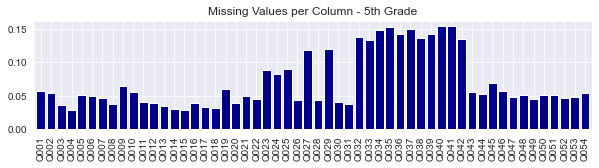

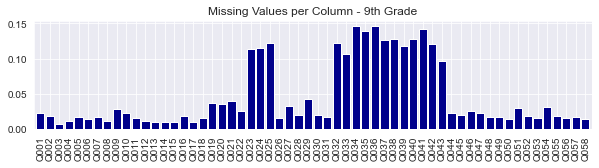

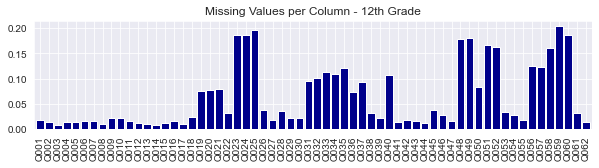

In [128]:
titles = [f'Missing Values per Column - {s}' for s in ['5th Grade', '9th Grade', '12th Grade']]

limits = [54, 58, 62]

for i in range(3):
    
    fig = plt.figure(figsize=(10,2))

    empty_cells[i].iloc[:limits[i]].plot.bar(width=0.85, color='darkblue', title=titles[i])
    
    
    fig.savefig(f'Plots/Data Cleaning/{titles[i]}.png', bbox_inches='tight')
    plt.show()
    

### Filling missing Values with dot mark

In [129]:
qst_raw.replace(np.nan, '.', inplace=True)

### Droping constant columns

In [130]:
out_cols = ['ID_SAEB', 'IN_SITUACAO_CENSO', 'IN_PREENCHIMENTO']

for col in out_cols:
    print(col, dict(qst_raw[col].value_counts()))

ID_SAEB {2011: 849278}
IN_SITUACAO_CENSO {1: 849278}
IN_PREENCHIMENTO {1: 849278}


In [131]:
qst_raw.drop(out_cols, inplace=True, axis=1)

# 1.5 Saving Clean Dataset

In [132]:
std_qst_path = 'Data/Student_Socioeconomic_Questionnaire_clean.csv'

qst_raw.to_csv(std_qst_path, index=False); print(f'Saved at: {datetime.now()}')

Saved at: 2021-08-24 21:56:34.397639


---

# 1.6 Loading Students Grades Dataset

#### Excel to CSV Conversion

In [133]:
#res_alun = pd.read_excel('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\saep_res_aluno.xlsx')

#res_alun.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\CSV\saep_res_aluno.csv', index=False)  12/03/2021 (17:00)

### Loading

In [18]:
grades_filename = 'saep_res_aluno.csv'
res_alun = pd.read_csv(data_path.format(grades_filename))

id_cols = res_alun.columns[:15].tolist(); notas_cols = res_alun.columns[-10:-1].tolist()

In [19]:
pd.DataFrame(res_alun.shape, index=['Rows', 'Columns'], columns=['Count'])

,Count
Rows,1048575
Columns,25


# 1.7 Saving Dataset as Image

### Saving Ids

In [135]:
perf = res_alun[id_cols].head().set_index('ID_ALUNO').T; dfi.export(perf, 'Tables/Data Cleaning/Grades_Ids_Table_Head.png'); perf

ID_ALUNO,204319,204320,907687,1611630,1611631
ID_SAEB,2011,2011,2011,2011,2011
ID_REGIAO,1,1,1,1,1
ID_UF,11,11,11,11,11
ID_MUNICIPIO,1100015,1100015,1100015,1100015,1100015
ID_ESCOLA,11024682,11024682,11024682,11024682,11024682
ID_DEPENDENCIA_ADM,2,2,2,2,2
ID_LOCALIZACAO,1,1,1,1,1
ID_CAPITAL,2,2,2,2,2
ID_TURMA,52401,52401,52401,52401,52401
ID_TURNO,2,2,2,2,2


### Saving Grades

In [136]:
grades = res_alun[notas_cols+['ID_ALUNO']].head().set_index('ID_ALUNO').T; dfi.export(grades, 'Tables/Data Cleaning/Grades_Cols_Head.png'); grades

ID_ALUNO,204319,204320,907687,1611630,1611631
PESO,,1.2,1.2,1.2,1.2
PROFICIENCIA_LP,,-0.543135,-2.067546,-1.014258,-1.528384
DESVIO_PADRAO_LP,,0.335023,0.385162,0.350205,0.329361
PROFICIENCIA_LP_SAEB,,220.061856395622,136.076928116311,194.106106033198,165.781175790285
DESVIO_PADRAO_LP_SAEB,,18.4575436853444,21.2198698027736,19.293971119374,18.1456050651708
PROFICIENCIA_MT,,-0.561132,-0.052366,-0.817919,-0.669903
DESVIO_PADRAO_MT,,0.324852,0.355331,0.357318,0.313721
PROFICIENCIA_MT_SAEB,,218.601407260817,247.037523357189,204.24898405636,212.521942862806
DESVIO_PADRAO_MT_SAEB,,18.1567345029708,19.8602767650349,19.9713348205722,17.5345970011159


# 1.8 Cleaning

#### Changing empty cells notation to "NAN" & type conversion

In [137]:
res_alun_clean = res_alun.copy()

notas_cols = res_alun.columns[-10:-1].tolist() #Colunas Correspondentes às Notas dos Alunos
res_alun_clean[notas_cols] = res_alun[notas_cols].replace(' ', np.nan).astype(float)

#### Conting and eliminating completely empty rows.

In [138]:
empty_row_cnt = res_alun_clean[notas_cols].isnull().all(1).sum()
part_empty_row_cnt = res_alun_clean[notas_cols].isnull().any(1).sum()
a = empty_row_cnt/len(res_alun_clean); b = part_empty_row_cnt/len(res_alun_clean)

print(f'Completely Empty Rows: {round(a, 3)*100}%')
print('Obs: All Remaining Rows Are Complete.')

Completely Empty Rows: 18.8%
Obs: All Remaining Rows Are Complete.


#### Droping Completely Empty Rows

In [139]:
res_alun_nao_vazio = res_alun_clean.dropna(how='all', subset=notas_cols)

#### Extracting Columns of Interest

In [140]:
keep_cols_res_aluno = ['ID_ALUNO', 'PESO', 'PROFICIENCIA_LP',
                       'DESVIO_PADRAO_LP', 'PROFICIENCIA_LP_SAEB', 'DESVIO_PADRAO_LP_SAEB',
                       'PROFICIENCIA_MT', 'DESVIO_PADRAO_MT', 'PROFICIENCIA_MT_SAEB',
                       'DESVIO_PADRAO_MT_SAEB']

res_alun_final = res_alun_nao_vazio[keep_cols_res_aluno]

# 1.9 Saving Clean Students Grades Dataset

In [141]:
res_alun_final.to_csv('Data/Student_grades_clean.csv', index=False); print(f'Saved at: {datetime.now()}')

Saved at: 2021-08-24 21:57:29.067493


#### Reloading

---
# 2. DATA TRANSFORMATION

#### Loading Clean Data

In [516]:
qst_clean = pd.read_csv('Data/Student_Socioeconomic_Questionnaire_clean.csv')
grade_data = pd.read_csv('Data/Student_grades_clean.csv')

#### Counting students of each grade

In [517]:
grades = [5,9,12]; count = [qst_clean[qst_clean['ID_SERIE']==grade].shape[0] for grade in grades]

std_cnt = pd.DataFrame(count+[sum(count)], index=grades+['Total'], columns=['Student Count']); std_cnt.index.name='Grade';

dfi.export(std_cnt, 'Tables/Data Transformation/Student_Count.png'); std_cnt

,Student Count
Grade,
5,468706
9,360455
12,20117
Total,849278


# 2.1 Extracting 9th Grade Data

In [518]:
qst_aluno = qst_clean[qst_clean['ID_SERIE']==9].copy()

#### Extracting ids and questions columns, defining the target variable and listing the table features

In [519]:
ids_cols = qst_aluno.columns[:12]; qst_cols = qst_aluno.columns[12:] 

target = 'TX_RESP_Q050' # Abandonment
# target = 'TX_RESP_Q049' # Reproval

features = [col for col in qst_aluno.columns if col!=target]

In [520]:
target_info = dicts[1].loc[[target]].dropna(how='all', axis=1).T;
dfi.export(target_info, 'Tables/Data Transformation/Target_Variable_Info.png'); target_info

questão,TX_RESP_Q050
Enunciado,Você já abandonou a escola durante o período de aulas e ficou fora da escola o resto do ano?
A,Não.
B,"Sim, uma vez."
C,"Sim, duas vezes ou mais."


### 2.2.1. Target Variable Classes Transformation
1. Droping rows where the target variable is missing 
2. Target variable conversion to binary
3. Label Encoding Target

In [521]:
qst_filt = filtrar_categorias(qst_aluno, target,
                              ctgr_lst=['A', 'B', 'C'],
                              replace_dict={'C':'B'},
                              encode=True) # (qst_aluno, target, ['A', 'B', 'C'])   # Eliminando questionários com reprovação vazia

Construindo Index...
Extraindo Dados da Tabela...
Substituindo Categorias: {'C': 'B'}
Rotulando Variável Alvo...

Categorias Atualizadas!


## 2.3 Class Count - Before and After

In [522]:
cls_cnt = qst_aluno[target].value_counts().to_frame().rename(columns={target:'Count'});

cls_cnt.index.name='Class'; cls_cnt['Abandonment'] = ['No, never', 'Yes, once', 'Yes, twice or more', 'Missing']

dfi.export(cls_cnt, 'Tables/Data Transformation/Class_Count_Original.png'); cls_cnt

,Count,Abandonment
Class,,
A,326989,"No, never"
B,21818,"Yes, once"
C,6401,"Yes, twice or more"
.,5247,Missing


In [523]:
cls_cnt_filt = qst_filt[target].value_counts().to_frame().rename(columns={target:'Count'});

cls_cnt_filt.index.name='Class'; cls_cnt_filt['Abandonment'] = ['No, never', 'Yes, once or more']

dfi.export(cls_cnt_filt, 'Tables/Data Transformation/Class_Count_Filtered.png'); cls_cnt_filt

,Count,Abandonment
Class,,
0,326989,"No, never"
1,28219,"Yes, once or more"


## 2.4 Adding Grade columns

In [524]:
grade_keep_cols = ['ID_ALUNO', 'PESO', 'PROFICIENCIA_LP', 'DESVIO_PADRAO_LP', 'PROFICIENCIA_MT', 'DESVIO_PADRAO_MT']
qst_filt = pd.merge(qst_filt, grade_data[grade_keep_cols], on='ID_ALUNO')

In [525]:
cls_cnt_filt = qst_filt[target].value_counts().to_frame().rename(columns={target:'Count'});

cls_cnt_filt.index.name='Class'; cls_cnt_filt['Alternative'] = ['No, never', 'Yes, once at least']

dfi.export(cls_cnt_filt, 'Tables/Data Transformation/Class_Count_Filtered_Grades.png'); cls_cnt_filt

,Count,Alternative
Class,,
0,326976,"No, never"
1,28217,"Yes, once at least"


## 2.5 Scaling Float Columns

In [526]:
float_cols = qst_filt.dtypes[qst_filt.dtypes==float].index

qst_filt[float_cols] = mms().fit_transform(qst_filt[float_cols])

## 2.6 Label Encoding Categorical Features

In [527]:
qst_enc = encode(qst_filt, label_cols=features)[0]

Rotulando Variáveis Categóricas... -  72 / 73


In [528]:
qst_enc.dtypes.value_counts().to_frame().rename(columns={0:'Column Count'})

,Column Count
int32,62
int64,12
float64,5


## 2.7 Excluding Biased or Constant Features

In [529]:
constant_columns = [col for col in Q_columns.tolist() if (len(qst_enc[col].value_counts())==1)]; constant_columns

['TX_RESP_Q059', 'TX_RESP_Q060', 'TX_RESP_Q061', 'TX_RESP_Q062']

In [530]:
new_features = [col for col in features + grade_data[grade_keep_cols].columns.tolist() if col not in ['ID_ALUNO', 'ID_SERIE']+constant_columns]

qst_final = qst_enc[[target] + new_features].copy()

## 2.8 Saving Transformed Data

In [531]:
qst_final.head()

,TX_RESP_Q050,ID_REGIAO,ID_UF,ID_MUNICIPIO,ID_ESCOLA,ID_DEPENDENCIA_ADM,ID_LOCALIZACAO,ID_CAPITAL,ID_TURMA,ID_TURNO,...,TX_RESP_Q054,TX_RESP_Q055,TX_RESP_Q056,TX_RESP_Q057,TX_RESP_Q058,PESO,PROFICIENCIA_LP,DESVIO_PADRAO_LP,PROFICIENCIA_MT,DESVIO_PADRAO_MT
0,0,0,0,0,215,1,0,1,6219,1,...,1,1,1,2,3,0.001285,0.870545,0.515232,0.570345,0.219145
1,0,0,0,0,215,1,0,1,6219,1,...,1,1,1,2,3,0.001285,0.663241,0.220093,0.675989,0.100196
2,0,0,0,0,215,1,0,1,6219,1,...,1,1,1,3,3,0.001285,0.457957,0.181639,0.385850,0.277198
3,0,0,0,0,215,1,0,1,6219,1,...,1,1,1,3,1,0.001285,0.575003,0.114148,0.365701,0.193304
4,0,0,0,0,215,1,0,1,6219,1,...,1,2,1,2,3,0.001285,0.503797,0.129299,0.616235,0.160079


In [532]:
qst_final.to_csv('Data/9th_grade_transformed_data.csv'); print(f'Saved at: {datetime.now()}')

Saved at: 2021-08-25 23:40:05.814043


---

# 3. Sampling Training and Testing Datasets

#### Loading Prepared Data

In [533]:
qst_final = pd.read_csv('Data/9th_grade_transformed_data.csv', index_col=0)

#### Defining target and features variables

In [534]:
target = 'TX_RESP_Q050' # Abandonment
features = [col for col in qst_final.columns if col!=target]
new_features = [col for col in features if col not in ['ID_ALUNO', 'ID_SERIE']]

### Sampling Training and Testing Datasets (Binary Classes Proportion: 1/1)

In [535]:
train_set, test_set = binary_sample(qst_final, target, testing=[10000, 10000], training=[3000, 3000], path='Tables/Evaluation/Sampling.png')

Contagem Abandono:


,Original,Treinamento,Teste
Regular,326976,3000,10000
Abandono,28217,3000,10000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


# 4. CLASSIFICATION MODELS COMPARISON

# 4.1 Setting

#### Excluding Data Intensive Models

In [536]:
out = ['CategoricalNB', 'GaussianProcessClassifier', 'RadiusNeighborsClassifier',
       'ClassifierChain', 'MultiOutputClassifier', 'OneVsOneClassifier',
       'OneVsRestClassifier', 'OutputCodeClassifier', 'StackingClassifier',
       'VotingClassifier', 'LabelPropagation']

classifiers = all_estimators('classifier')
models_dict = dict(classifiers)
names, models = list(models_dict.keys()), list(models_dict.values())

models = [model for model, name in zip(models, names) if name not in out]
names = [name for name in names if name not in out]
print(len(names), len(models), len(out), len(models_dict))

30 30 11 41


#### High Accuracy Models

In [537]:
top_names = ['AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier',
             'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'RandomForestClassifier']
top_models = [models_dict[name] for name in top_names]

# 4.2 Training/Scoring Multiple Models

In [538]:
scrs_label = scr_models(train_set, test_set, target, models, names); 

#scrs_label.to_csv('Data/Evaluation/classification_model_comparison.csv'); print(f'\nSaved at: {datetime.now()}')


Avaliando Modelo SVC - (30/30)

Construindo Modelo SVC...
Fitting...
Predicting...
Scoring...


# 4.3 Classification Models Performance Visualization

#### Loading Evaluation

In [553]:
scrs_label = pd.read_csv('Data/Evaluation/classification_model_comparison.csv', index_col=0)

### 4.3.1 Classification Models Accuracies - Barplot

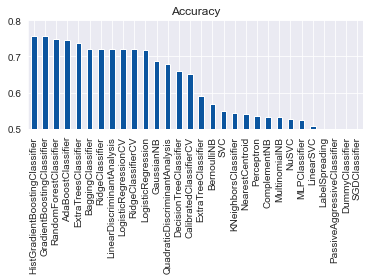

In [857]:
#palettes = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
palettes=['Blues_r']
for palette in palettes:

    sns.set_palette(palette)


    fig = plt.figure(figsize=(6,2))
    scrs_label['accuracy'].sort_values(ascending=False).plot.bar(ylim=(0.5, 0.8), title='Accuracy'); 
    
    plt.show(); plt.pause(.1); fig.savefig('Plots/Evaluation/Classification_Comparison_Barplot.png', bbox_inches='tight')
    #if input(palette)=='exit': break
    
    clear_output(wait=True)

### 4.3.2 Classification Models Evaluation - Heatmap

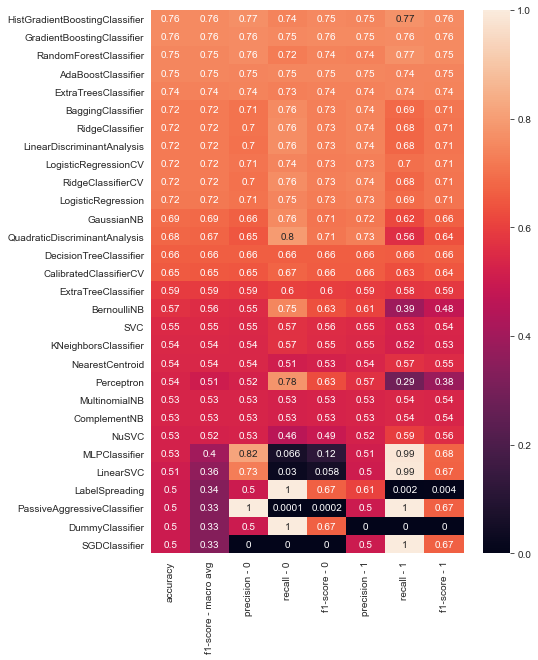

In [555]:
cls_scrs = ['accuracy', 'f1-score - macro avg',
            'precision - 0', 'recall - 0', 'f1-score - 0',
            'precision - 1', 'recall - 1', 'f1-score - 1']

fig = plt.figure(figsize=(7,10)); sns.heatmap(scrs_label[cls_scrs].sort_values('accuracy', ascending=False), annot=True);
plt.show(); fig.savefig('Plots/Evaluation/Classification_Comparison_Heatmap.png', bbox_inches='tight')

### 4.3.3 Classification Models Evaluation - Heatmap (Top 20)

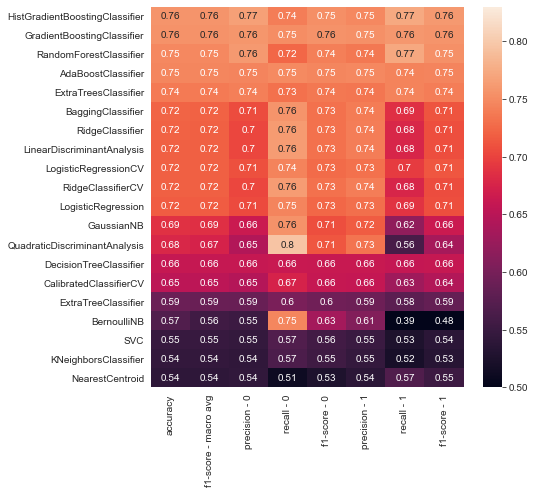

In [556]:
fig = plt.figure(figsize=(7,7)); sns.heatmap(scrs_label[cls_scrs].sort_values('accuracy', ascending=False).head(20), annot=True, vmin=0.5, vmax=.83);
plt.show(); fig.savefig('Plots/Evaluation/Classification_Comparison_Heatmap_head.png', bbox_inches='tight')

# 5. REGRESSION MODELS COMPARISON

In [557]:
def round_pred(pred, p_max=0.5): return np.array([0 if y < p_max else 1 for y in pred])

# 5.1 Setting regression models

1. Measuring execution time
2. Visualizing execution time
3. Excluing Data Intensive Models

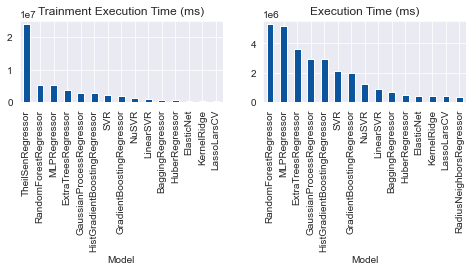

In [558]:
# -----  MEASURING MODEL CONSTRUCTION EXECUTION TIME  --------------

regressors = dict(all_estimators('regressor'))
small_sample = train_set.sample(2000); xs = small_sample[features]; ys = small_sample[target]

reg_mdls = {}; fail = []; exe_time = []; cnt = 0; n = len(regressors)
for name, reg_mdl in regressors.items():
    
    cnt+=1; print(f'{cnt}/{n} - {name}'); clear_output(wait=True)
    
    try:
        
        t0 = datetime.now()
        scr = classification_report(ys, round_pred( reg_mdl().fit(xs, ys).predict(xs) ), output_dict=True)
        dt = datetime.now() - t0
        
        exe_time.append([name, dt.seconds*1e6 + dt.microseconds])
        reg_mdls[name] = reg_mdl
        
    except:
        
        fail.append(name)

exe_df = pd.DataFrame(exe_time, columns=['Model', 'exe_time']).set_index('Model')['exe_time'].sort_values(ascending=False)

# ----  VISUALIZING  --------

fig = plt.figure(figsize=(8,1.5)); axes = [fig.add_subplot(1,2,i) for i in [1,2]]

exe_df.head(15).plot.bar(ax=axes[0], title='Trainment Execution Time (ms)')
exe_df.drop(exe_df.index[0]).head(15).plot.bar(ax=axes[1], title='Execution Time (ms)');

(ax.set(xlabel='Regression Model') for ax in axes)
plt.show(); fig.savefig('Plots/Evaluation/Regression - Execution Time.png', bbox_inches='tight')

# ----  EXCLUDING DATA INTENSIVE MODELS  --------

del reg_mdls[exe_df.index[0]]


# 5.2 Training and Saving

In [559]:
models_path = 'Models/Regression/{}.csv'

x, x_tst = [df[features] for df in [train_set, test_set]]
y, y_tst = [df[target] for df in [train_set, test_set]]

cnt = 0; n = len(reg_mdls);

for name, reg_mdl in reg_mdls.items():
    
    joblib.dump(reg_mdl().fit(x, y), models_path.format(name))
    cnt+=1; print(f'{cnt+1}/{n} - {name}'); clear_output(wait=True)
    
print(f'Regressions Models Saved at: {datetime.now()}')

Regressions Models Saved at: 2021-08-26 00:07:20.657650


# 5.3 Loading and Scoring

In [560]:
cols = ['acc', 'precision 0', 'recall 0', 'f1-score 0', 'precision 1', 'recall 1', 'f1-score 1', 'precision', 'recall', 'f1-score']

reg_scrs = []; cnt = 0; n = len(reg_mdls)
for name in reg_mdls.keys():
    
    mdl = joblib.load(models_path.format(name)); mdl_pred = round_pred(mdl.predict(x_tst), p_max=0.5)

    cr = classification_report(y_tst, mdl_pred, output_dict=True)

    if cnt==0: metrics = list(cr['0'].keys())[:-1]
    #cols = ['acc'] + [col+' 0' for col in metrics] + [col+' 1' for col in metrics] + list(cr['macro avg'].keys())[:-1]

    row = [cr['accuracy']] + list(cr['0'].values())[:-1] + list(cr['1'].values())[:-1] + list(cr['macro avg'].values())[:-1]                 
                      
    reg_scrs.append([name] + row)

    cnt+=1; print(f'{cnt+1}/{n}  -  {name}'); clear_output(wait=True)

reg_df = pd.DataFrame(reg_scrs, columns=['Regressor'] + cols).set_index('Regressor')
reg_df.to_csv('Data/Evaluation/regression_model_comparison.csv'); print(f'\nSaved at: {datetime.now()}')


Saved at: 2021-08-26 00:09:57.647015


# 5.4 Regression Models Evaluation - Heatmap

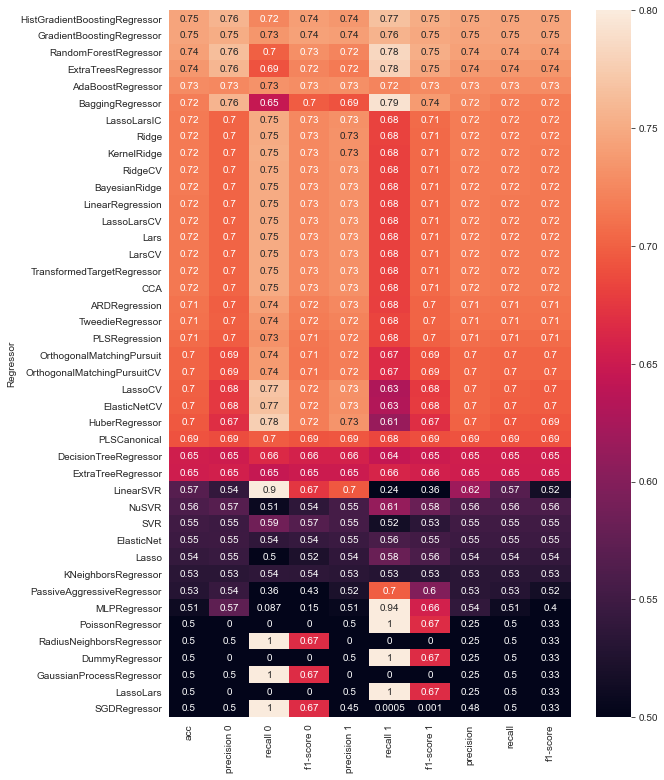

In [561]:
fig = plt.figure(figsize=(9,13)); sns.heatmap(reg_df.sort_values('acc', ascending=False), annot=True, vmin=0.5, vmax=.8)
plt.show(); fig.savefig('Plots/Evaluation/Regression_Comparison_Heatmap.png', bbox_inches='tight')

# 5.4 Regression Models Evaluation - Heatmap (Top 20)

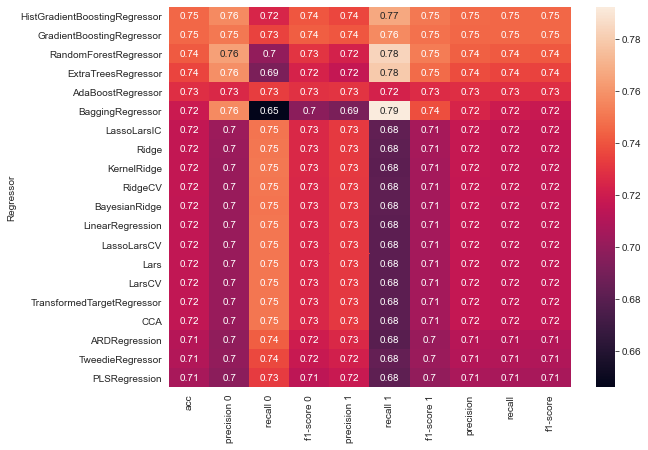

In [562]:
fig = plt.figure(figsize=(9,7)); sns.heatmap(reg_df.sort_values('acc', ascending=False).head(20), annot=True)
plt.show(); fig.savefig('Plots/Evaluation/Regression_Comparison_Heatmap_head.png', bbox_inches='tight')

---
# 5. Classes Proportion Optimization - Unbalanced Classes Case

### 5.1 Optimization Conditions

In [764]:
class_sample_size = 20000; class_test_size=5000

class_grid_size = 25

class_dgrs = [3 , 3]

x , y = 'Never Dropped Out', 'Dropped Out'

### 5.1 Sampling

In [765]:
train_full, test_full = binary_sample(qst_final, target, testing=[class_test_size]*2, training=[class_sample_size]*2, path='Tables/Class Proportion Optimization/Sampling.png')

Contagem Abandono:


,Original,Treinamento,Teste
Regular,326976,20000,5000
Abandono,28217,20000,5000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


### 5.2 Grid Evaluation

In [767]:
opt_result, exe_time = size_opt(train_full, test_full, target,
                                top_models[1:], top_names[1:],
                                'Data/Class Proportion Optimization/Per Model/{}.csv',
                                n_cat0=class_grid_size, n_cat1=class_grid_size,
                                degree_cat0=class_dgrs[0], degree_cat1=class_dgrs[1],
                                cats_names=[x, y], history=[])

Proporção Categorias 
X0: 20000 X1: 20000 -  624/625  (99.84%)

Construindo index...
Retirando Amostra...

Construindo Modelo RandomForestClassifier...
Fitting...
Predicting...
Scoring...


### Reloading History

In [768]:
top_names

['AdaBoostClassifier',
 'BaggingClassifier',
 'ExtraTreesClassifier',
 'GradientBoostingClassifier',
 'HistGradientBoostingClassifier',
 'RandomForestClassifier']

In [769]:
sizes_history = []
path = 'Data/Class Proportion Optimization/Per Model/{}.csv'
for name in os.listdir('Data/Class Proportion Optimization/Per Model/'):
    sizes_history.append([name, pd.read_csv(path.format(name[:-4]), index_col=0)])

In [770]:
dfs = [sizes_history[i][1] for i in range(len(sizes_history))]
#x, y = 'Nunca Reprovou', 'Reprovou'
for i in range(len(dfs)):
    dfs[i]['p']=dfs[i][x]/dfs[i][y]

### Controle do modelo para Visualização:

In [771]:
print(dict(sizes_history).keys())
i = -1

dict_keys(['AdaBoostClassifier.csv', 'BaggingClassifier.csv', 'ExtraTreesClassifier.csv', 'GradientBoostingClassifier.csv', 'HistGradientBoostingClassifier.csv', 'RandomForestClassifier.csv'])


In [775]:
i+=1
sizes_df = sizes_history[i][1]
sizes_df['p']=sizes_df[x]/sizes_df[y]

print('Modelo: {}'.format(sizes_history[i][0]))

Modelo: GradientBoostingClassifier.csv


### Extraindo x, y, z

In [776]:
xyz = [x, y, 'accuracy']

x, y, z = xyz
xs, ys, zs = [sizes_df[col] for col in xyz]

sizes_df['p']=sizes_df[x]/sizes_df[y]

xp, yp, zp = make_grid(sizes_df, xyz)
x_max, y_max, z_max = xyz_max(sizes_df, [x,y], z)

3D Grid:
(25, 25) (25, 25) (25, 25)
2D Arrays:
(25,) (29,) (25,)


### Visualização

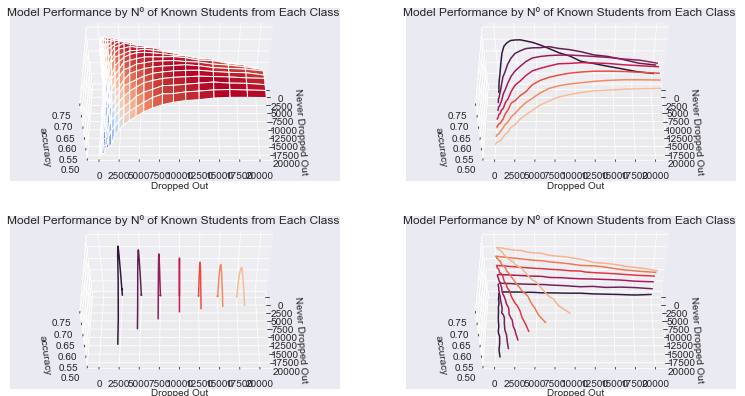

In [777]:
full_plot_3d(xp, yp, zp, title='Model Performance by Nº of Known Students from Each Class ',
             labels=[x, y, z], final_angle=361,
             path='Plots/Class Proportion Optimization/Sectional 3D Plots/'+sizes_history[i][0]+' - {}°.png')

AdaBoostClassifier


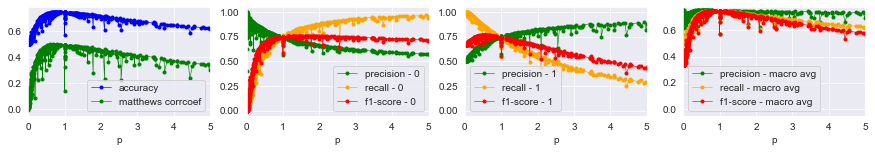

BaggingClassifier


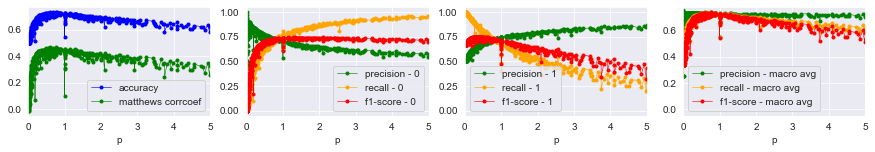

ExtraTreesClassifier


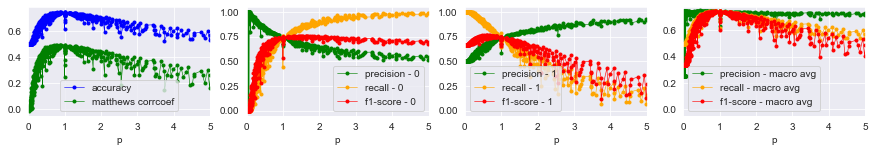

GradientBoostingClassifier


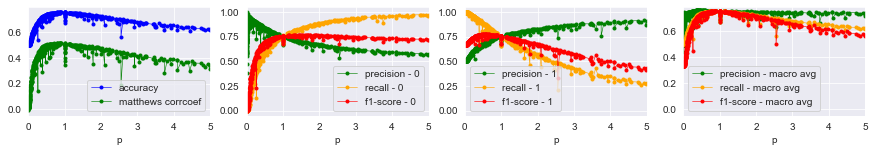

HistGradientBoostingClassifier


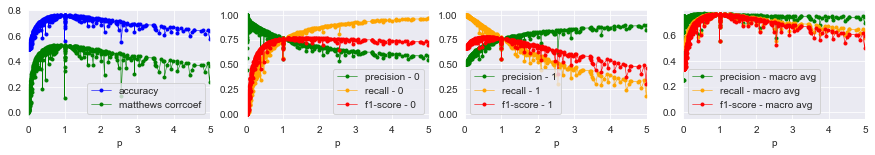

RandomForestClassifier


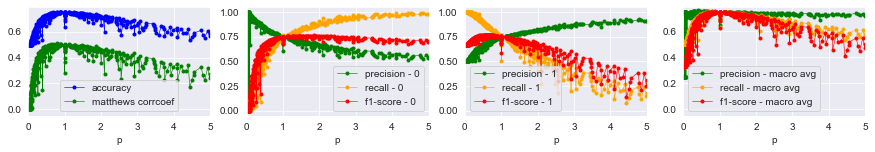

In [778]:
for df, name in zip(dfs, top_names):
    print(name)
    report_2d(df, 'p', scatter=False, ms=3, marker='o', lw=0.6, xlim=(0,5), path=f'Plots/Class Proportion Optimization/Line Plots/{name}.png')

#### Obs: Exposes Optimal Proportions and Maximum Accuracies

### Optimal proportions determination using Linear Regression

In [779]:
#x, y = 'Nunca Reprovou', 'Reprovou'
x,y = 'Never Dropped Out', 'Dropped Out'
base_variable = 'f1-score - weighted avg' # 'accuracy'

max_dfs = []
coefs = []
n = len(sizes_history)
for i in range(n):
    
    name = sizes_history[i][0][:-4]; sizes_df = sizes_history[i][1]; sizes_df['p']=sizes_df[x]/sizes_df[y]

    xs = sorted(sizes_df[x].unique().tolist())
    maximuns = []

    for x_i in xs:

        df_i = sizes_df[sizes_df[x]==x_i]; row_i = df_i[df_i[base_variable]==df_i[base_variable].max()]
        p_i, y_i, acc_i = row_i['p'][0], row_i[y][0], row_i[base_variable][0]

        maximuns.append((pd.Series([x_i, y_i, p_i, acc_i])))

    max_df = pd.concat(maximuns, 1).T; max_df.columns = [x, y, 'p', base_variable]; max_df['model']=name
    model = lr(fit_intercept=False).fit(max_df[[x]], max_df[[y]])
    
    r2 = r2_score(max_df[[y]], model.predict(max_df[[x]]))
    
    max_dfs.append(max_df); 
    coefs.append([name, model.coef_[0][0], r2])

    clear_output(wait=True)
    print(i+1, '/', n)
    
max_dfs = pd.concat(max_dfs, 0)
coefs = pd.DataFrame(coefs, columns=['model', 'a', 'r2']).set_index('model')

6 / 6


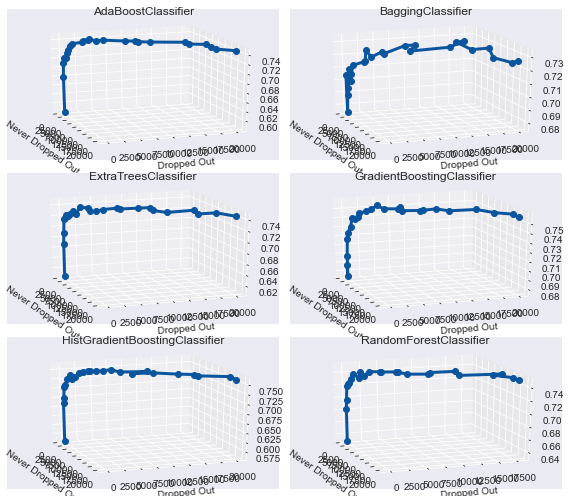

In [780]:
base_variable = 'f1-score - weighted avg'
ps = []
for angle in range(0, 360, 20):
    
    fig = plt.figure(figsize=(8,7), tight_layout=True); axs = [fig.add_subplot(3,2,i+1, projection='3d') for i in range(6)]
    for i, model in enumerate(max_dfs['model'].unique()):

        df = max_dfs[max_dfs['model']==model]   # Linha precisões máximas
        axs[i].plot(df[x], df[y], df[base_variable], lw=3, marker='o')

        
        axs[i].set(title=model, xlabel=x, ylabel=y)
        ps.append((yi[0]/xi)[0])
        
        axs[i].view_init(20, angle)
    
    clear_output(wait=True)
    plt.pause(0.001)
    plt.show()
    fig.savefig(f'Plots/Class Proportion Optimization/Optimal Points 3D/3D Line Plot - {angle}°.png', bbox_inches='tight')
    

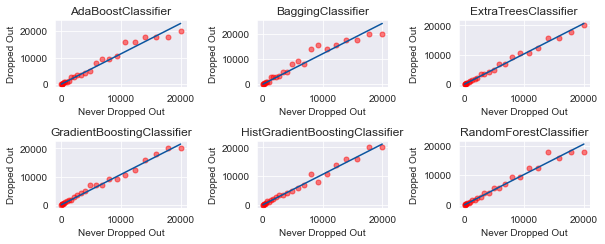

In [781]:
fig = plt.figure(figsize=(8.5,3.5), tight_layout=True); axs = [fig.add_subplot(2,3,i+1) for i in range(6)]
ps = []
for i, model in enumerate(max_dfs['model'].unique()):
    
    df = max_dfs[max_dfs['model']==model]
    axs[i].plot(df[x], df[y], marker='o', color='red', alpha=0.5, lw=0, ms=5)
        
    a = coefs.loc[model]['a']
    xi = np.linspace(0, class_sample_size, 100)
    yi = a*xi
    axs[i].plot(xi, yi)
    axs[i].set(title=model, xlabel=x, ylabel=y)
    
    ps.append((xi/yi)[0])
    
plt.show()
fig.savefig('Plots/Class Proportion Optimization/2D Regression.png', bbox_inches='tight')

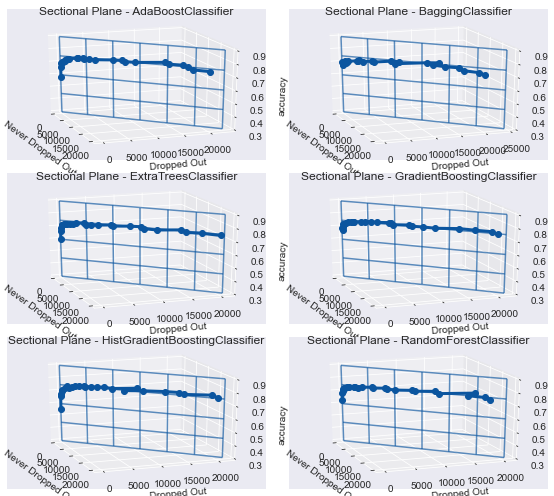

In [782]:
base_variable = 'f1-score - weighted avg'
ps = []
for angle in range(0, 360, 21):
    
    fig = plt.figure(figsize=(8,7), tight_layout=True); axs = [fig.add_subplot(3,2,i+1, projection='3d') for i in range(6)]
    for i, model in enumerate(max_dfs['model'].unique()):

        df = max_dfs[max_dfs['model']==model]   # Linha precisões máximas
        axs[i].plot(df[x], df[y], df[base_variable], lw=3, marker='o')

        a = coefs.loc[model]['a']
        xi = np.linspace(1, class_sample_size, 25)
        yi = np.array([a*xi] * 25)
        zi = np.linspace(0.3, 0.9, 25)
        xgrid, zgrid = np.meshgrid(xi, zi)
        axs[i].plot_wireframe(xgrid, yi, zgrid, alpha=0.65, cstride=4, rstride=6)   # Planos verticais
        
        axs[i].set(title=f'Sectional Plane - {model}', xlabel=x, ylabel=y, zlabel=z)
        ps.append((yi[0]/xi)[0])
        
        axs[i].view_init(20, angle)
    
    clear_output(wait=True)
    plt.pause(0.001)
    plt.show()
    fig.savefig(f'Plots/Class Proportion Optimization/Intersection Planes 3D/3D-Line-Plane - {angle}°.png', bbox_inches='tight')


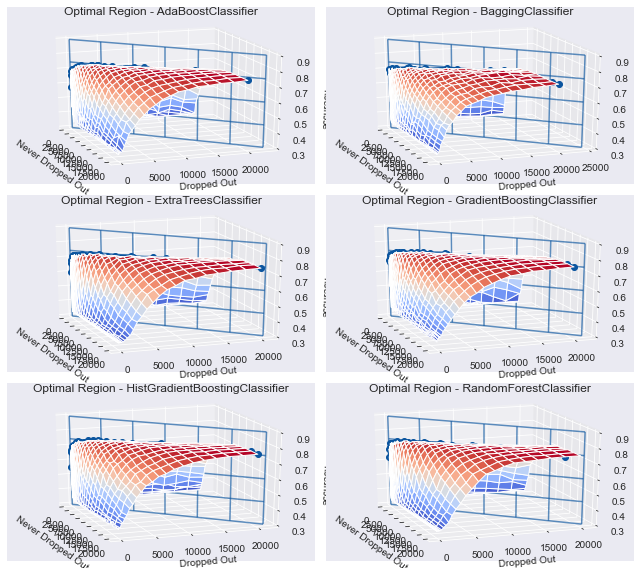

In [783]:
base_variable = 'f1-score - weighted avg'
ps = []
for angle in range(0, 360, 21):
    
    fig = plt.figure(figsize=(9,8), tight_layout=True); axs = [fig.add_subplot(3,2,i+1, projection='3d') for i in range(6)]
    for i, model in enumerate(max_dfs['model'].unique()):

        df = max_dfs[max_dfs['model']==model]   # Linha precisões máximas
        axs[i].plot(df[x], df[y], df[base_variable], lw=3, marker='o')

        a = coefs.loc[model]['a']
        xi = np.linspace(1, class_sample_size, 25)
        yi = np.array([a*xi] * 25)
        zi = np.linspace(0.3, 0.9, 25)
        xgrid, zgrid = np.meshgrid(xi, zi)
        axs[i].plot_wireframe(xgrid, yi, zgrid, alpha=0.65, cstride=4, rstride=6)   # Planos verticais

        size_df = sizes_history[i][1]
        xs, ys, zs = make_grid(size_df, [x, y, base_variable], verbose=0)
        axs[i].plot_surface(xs, ys, zs, alpha=1, cmap='coolwarm')      # Precision Surface
        
        axs[i].set(title=f'Optimal Region - {model}', xlabel=x, ylabel=y, zlabel=z)
        ps.append((yi[0]/xi)[0])
        
        axs[i].view_init(20, angle)
    
    clear_output(wait=True)
    plt.pause(0.001)
    plt.show()
    fig.savefig(f'Plots/Class Proportion Optimization/Surface-Plane Intersection 3D/3D Surface-Plane - {angle}°.png', bbox_inches='tight')


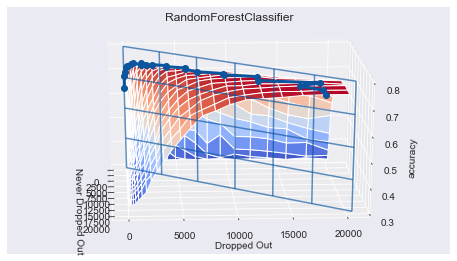

In [784]:
base_variable = 'f1-score - weighted avg'
[print([i, name]) for i, name in enumerate(top_names)]
control = int(input('Insira o índice para visualização'))

for angle in range(0, 360, 7):
    
    fig = plt.figure(figsize=(27, 10)); axs = fig.add_subplot(2,3,1, projection='3d')
    for i, model in enumerate(top_names):
        
        if i == control:

            df = max_dfs[max_dfs['model']==model]   # Linha precisões máximas
            axs.plot(df[x], df[y], df[base_variable], lw=3, marker='o')

            a = coefs.loc[model]['a']
            xi = np.linspace(1, class_sample_size, 25)
            yi = np.array([a*xi] * 25)
            zi = np.linspace(0.3, 0.8, 25)
            xgrid, zgrid = np.meshgrid(xi, zi)
            axs.plot_wireframe(xgrid, yi, zgrid, alpha=0.65, cstride=4, rstride=6)   # Planos verticais

            size_df = sizes_history[i][1]
            xs, ys, zs = make_grid(size_df, [x, y, base_variable], verbose=0)
            axs.plot_surface(xs, ys, zs, alpha=1, cmap='coolwarm')


            axs.set(title=model, xlabel=x, ylabel=y, zlabel=z)
            axs.view_init(20, angle)

    clear_output(wait=True)
    plt.pause(0.001)
    plt.show()
    

In [785]:
dfi.export(coefs, 'Tables/Optimal Class Proportions - Regression.png' ); coefs

,a,r2
model,,
AdaBoostClassifier,1.139665,0.965464
BaggingClassifier,1.213678,0.939322
ExtraTreesClassifier,1.033014,0.993009
GradientBoostingClassifier,1.076263,0.989199
HistGradientBoostingClassifier,1.057620,0.984451
RandomForestClassifier,1.026000,0.974611


---

# 7. FEATURE IMPORTANCE ANALYSIS

# 7.1 Outputting Importances

## 7.1.1 Top Performance Classification Models Implicit importances

In [786]:
imp_names = ['AdaBoostClassifier',
             'ExtraTreesClassifier',
             'GradientBoostingClassifier',
             'RandomForestClassifier']

imp_models = [model for model, name in zip(top_models, top_names) if name in imp_names]
x_train, y_train = train_set[new_features], train_set[target]

imps= []; i=0
for model, name in zip(imp_models, imp_names):

    i+=1; clear_output(wait=True); print('Fitting Model {}  -  {}/{}'.format(name, i, len(imp_names)))    
    imps.append(model().fit(x_train, y_train).feature_importances_)

Fitting Model RandomForestClassifier  -  4/4


In [787]:
imps_df = pd.DataFrame(imps, index=imp_names, columns=new_features)

## 7.1.2 Top Performance Regression Models Coefficients (Feature Importances)

#### Loading Constructed Regression Models

In [788]:
reg_built = []; cnt = 0; n = len(reg_mdls)
for name in reg_mdls.keys():
    
    cnt+=1; print(f'{cnt}/{n} - {name}'); clear_output(wait=True)
        
    reg_built.append(joblib.load(models_path.format(name)))

42/42 - TweedieRegressor


#### Extracting Regression Coefficients and Saving

In [789]:
reg_coefs = []; coef_fail = []; cnt = 0; n = len(reg_mdls)

for mdl, name in zip(reg_built, reg_mdls.keys()):
    
    cnt+=1; print(f'{cnt}/{n} - {name}'); clear_output(wait=True)
    
    try:
        coefs = list(mdl.coef_)
        if type(coefs[0])==np.ndarray: coefs = [item[0] for item in coefs]
        
        reg_coefs.append([name] + coefs)
        
    except: coef_fail.append(name)

reg_coef_df = pd.DataFrame(reg_coefs, columns=['Model']+features).set_index('Model')
reg_coef_df.to_csv('Data/Feature Importance/regression_coefficients.csv'); print(f'Saved at: {datetime.now()}')

Saved at: 2021-08-26 16:24:34.109078


#### Selecting Top Performance Regression Models

In [790]:
reg_coef_df = pd.read_csv('Data/Feature Importance/regression_coefficients.csv', index_col=0);

top_reg_coef = reg_coef_df.loc[[model for model in reg_df[reg_df['acc']>0.7]['acc'].sort_values(ascending=False).index.tolist() if model in reg_coef_df.index.tolist()]]

imps_df = imps_df.append([top_reg_coef.head(10)])

In [791]:
imps_df.T.head().T.head()

,ID_REGIAO,ID_UF,ID_MUNICIPIO,ID_ESCOLA,ID_DEPENDENCIA_ADM
AdaBoostClassifier,0.000000,0.000000,0.000000,0.040000,0.000000
ExtraTreesClassifier,0.007161,0.015574,0.016465,0.015612,0.010926
GradientBoostingClassifier,0.000000,0.000000,0.011406,0.021695,0.000000
RandomForestClassifier,0.003268,0.013029,0.033597,0.033821,0.005331
LassoLarsIC,-0.029368,-0.005960,0.000000,0.000000,-0.003990


## 7.1.3  Chi2 & f-classif test Importances

In [792]:
X, Y = train_set[new_features], train_set[target]
chi = chi2(X, Y); f = f_classif(X, Y)

chi_df, f_df = [ pd.DataFrame(df, columns=new_features, index=[method, 'p']).T.sort_values(method, ascending=False).head(10) for df, method in zip([chi, f], ['chi2', 'f_classif'])]
imps_df = imps_df.append([chi_df['chi2'],f_df['f_classif']])

# 7.1.4 Saving Feature Importances dataset

In [793]:
# imps_df.to_csv('Data/Feature Importance/feature_importances.csv'); print(f'Saved at: {datetime.now()}')

# 7.2 Importance Bar Charts

#### Loading feature Importances

In [3]:
imps_df = pd.read_csv('Data/Feature Importance/feature_importances.csv', index_col=0)

## 7.2.1 Feature Importances Heatmap

In [4]:
imps_df_mms = pd.DataFrame(mms().fit_transform(imps_df.T), columns=imps_df.index, index=imps_df.columns)

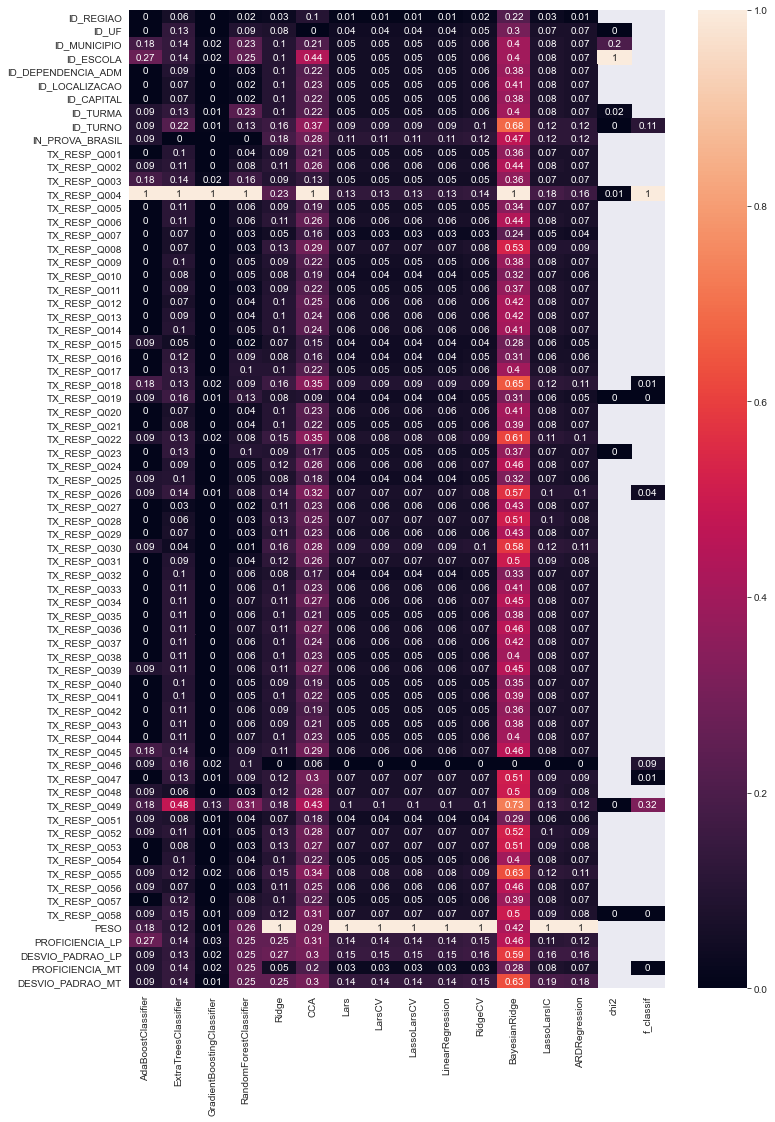

In [5]:
fig = plt.figure(figsize=(12,18)); sns.heatmap(round(imps_df_mms, 2), annot=True); plt.show(); fig.savefig(f'Plots/Feature Importance/Feature Importances Heatmap.png', bbox_inches='tight')

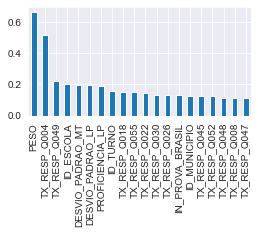

In [6]:
mean_rank = imps_df_mms.mean(1).sort_values(ascending=False)

fig = plt.figure(figsize=(4,2)); mean_rank.head(20).plot.bar()
plt.title='Average Feature Importance - Models and tests'

In [94]:
mean_rank

PESO                0.663613
TX_RESP_Q004        0.514248
TX_RESP_Q049        0.220132
ID_ESCOLA           0.203916
DESVIO_PADRAO_MT    0.195907
                      ...   
TX_RESP_Q015        0.069544
ID_UF               0.063412
TX_RESP_Q007        0.056517
ID_REGIAO           0.038984
TX_RESP_Q046        0.034560
Length: 72, dtype: float64

In [111]:
selected_features = [feature for feature in mean_rank.index if feature in dicts[1].index]
selected_ids = [feature for feature in mean_rank.index if feature not in dicts[1].index]
selected_ids = pd.Series(selected_ids, index=range(1, len(selected_ids)+1), name='Id Columns').to_frame()
selected_ids.index.name='Rank'
Final_Result_Questions = (dicts[1]
               .loc[selected_features]
               .dropna(how='all', axis=1)
               .replace(np.nan, '')
              # .head(10)
               )

Final_Result_Questions['Rank'] = range(1, len(selected_features)+1)
Final_Result_Questions = Final_Result_Questions.reset_index().set_index('Rank')
Final_Result_Questions.head(10)

,questão,Enunciado,A,B,C,D,E,F,G,H,I,J,K,L
Rank,,,,,,,,,,,,,,
1,TX_RESP_Q004,Em que ano você nasceu?,1999 ou depois.,1998.,1997.,1996.,1995.,1994.,1993.,1992 ou antes.,,,,
2,TX_RESP_Q049,Você já foi reprovado?,Não.,"Sim, uma vez.","Sim, duas vezes ou mais.",,,,,,,,,
3,TX_RESP_Q018,Você mora com sua mãe?,Sim.,Não. (passe para questão 22),"Não, moro com outra mulher responsável por mim.",,,,,,,,,
4,TX_RESP_Q055,Você faz o dever de casa de matemática?,Sempre ou quase sempre.,De vez em quando.,Nunca ou quase nunca.,,,,,,,,,
5,TX_RESP_Q022,Você mora com seu pai?,Sim.,Não. (passe para questão 26),"Não, moro com outro homem responsável por mim.",,,,,,,,,
6,TX_RESP_Q030,Seus pais ou responsáveis incentivam você a ir a escola e não faltar às aulas?,Sim.,Não.,,,,,,,,,,
7,TX_RESP_Q026,Com que frequência seus pais ou responsáveis vão à reunião de pais?,Sempre ou quase sempre.,De vez em quando,Nunca ou quase nunca.,,,,,,,,,
8,TX_RESP_Q045,"Em dias de aula, quanto tempo você gasta fazendo trabalhos domésticos?",1 hora ou menos.,2 horas.,3 horas.,4 horas ou mais.,Não faço trabalhos domésticos.,,,,,,,
9,TX_RESP_Q052,Você faz o dever de casa de língua portuguesa?,Sempre ou quase sempre.,De vez em quando.,Nunca ou quase nunca.,,,,,,,,,


In [114]:
selected_ids

,Id Columns
Rank,
1,PESO
2,ID_ESCOLA
3,DESVIO_PADRAO_MT
4,DESVIO_PADRAO_LP
5,PROFICIENCIA_LP
6,ID_TURNO
7,IN_PROVA_BRASIL
8,ID_MUNICIPIO
9,ID_TURMA


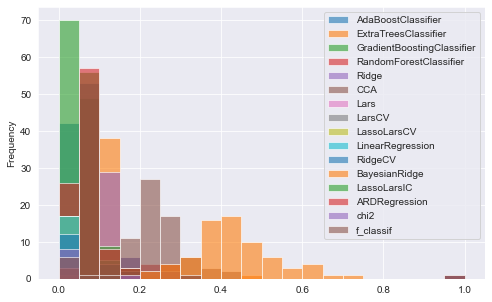

In [92]:
imps_df_mms.plot.hist(figsize=(8, 5), alpha=0.6, bins=20); plt.show()

## 7.2.2 Feature Importance Barplots

In [795]:
train_set['PESO'].describe()

count    6000.000000
mean        0.002015
std         0.007033
min         0.000000
25%         0.001036
50%         0.001225
75%         0.001573
max         0.228895
Name: PESO, dtype: float64

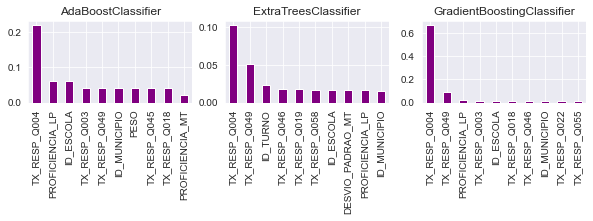

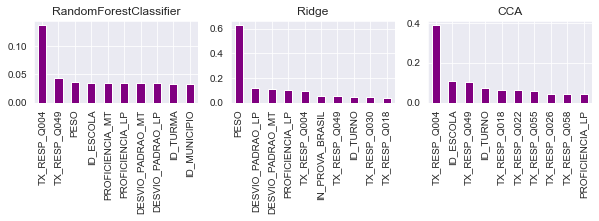

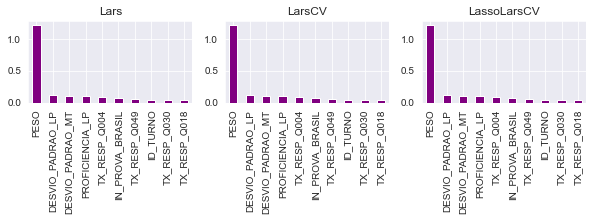

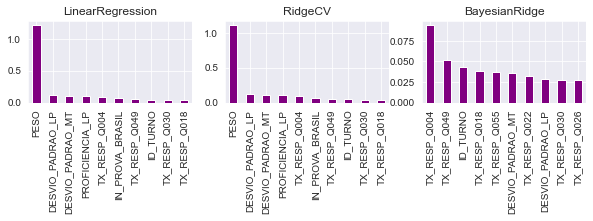

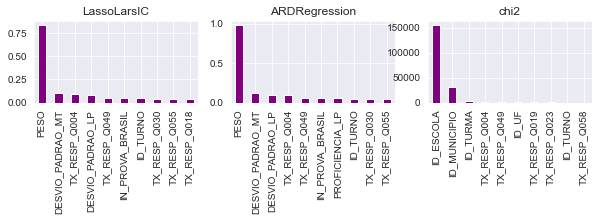

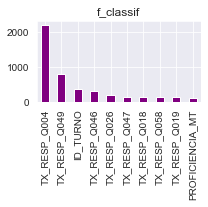

In [796]:
i=0; cnt=0; 
n_plots = len(imps_df)//3+1;
m = len(imps_df)%3

for i in range(n_plots):

    fig = plt.figure(figsize=(10,1.5))
    axs = [fig.add_subplot(1, 3, j) for j in range(1, (m+1 if i==n_plots-1 else 4))]
    
    for j in range(3 if i!=n_plots-1 else m):
        
        mdl_name = imps_df.index[cnt]; cnt+=1
        imps_df.loc[mdl_name].sort_values(ascending=False).head(10).plot.bar(ax=axs[j], color='purple')
        axs[j].set(title=mdl_name)
        
        
    plt.show()
    plt.pause(0.1)
    fig.savefig(f'Plots/Feature Importance/Per Model/Bar plots - {i+1}.png', bbox_inches='tight')
    


# 7.3 Feature Frequency Among Top 10 Most Important Features

In [797]:
def count_top_features(imps_df, n_top=10, plot=True, figsize=(6,2), width=0.5, head=None, proportion=False, path=None, clear=True):
    
    rank_rows = [imps_df.loc[model].sort_values(ascending=False).head(n_top).index for model in imps_df.index]
    ranks = pd.DataFrame(rank_rows, index=imps_df.index, columns=range(1, n_top+1)) 

    top_feats = np.unique(ranks)

    cnt_values = [sum([feat in ranks.loc[model].values for model in ranks.index]) for feat in top_feats ]
    feat_cnt = pd.Series(cnt_values , index=top_feats, name=n_top).sort_values(ascending=False)

    if type(head)==type(None): head=len(feat_cnt)

    fig = plt.figure(figsize=figsize); ax = fig.add_subplot(111, ylabel='Count'+(' Proportion (%)' if proportion else ''), xlabel='Feature')
    title_word =('Frequency' if not proportion else 'Proportion')
    title = ( f'Feature {title_word} Among Top {n_top} Most Important Features of 16 Models')

    (feat_cnt / (len(imps_df) if proportion else 1)).head(head).plot.bar(title=title,
                      width=width, color='purple'); 
 
    if plot: plt.show()
    if clear: clear_output(wait=True)
    if type(path)!=type(None): fig.savefig(path, bbox_inches='tight')

    return feat_cnt, top_feats

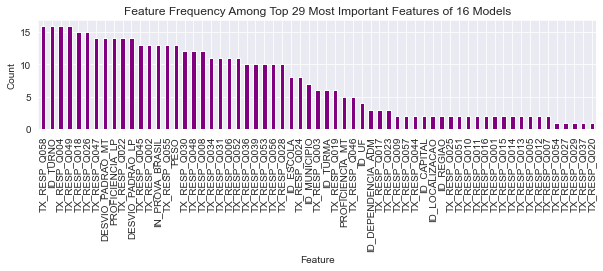

In [798]:
imps_3d = []
for n in range(3, 30):
    
    n_cnt, top_feats = count_top_features(imps_df, n_top=n, plot=True, figsize=((7 if n<20 else 10), 2),
                                          path=f'Plots/Feature Importance/Feature Frequency/Barplot - Top {n}.png')
    imps_3d.append(n_cnt)
    
frequency_counts = pd.concat(imps_3d, 1).T
frequency_counts.to_csv('Data/Feature Importance/features_frequencies.csv')

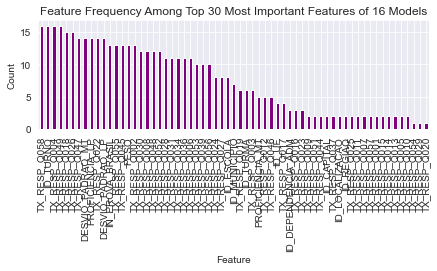

Saved at 2021-08-26 16:25:56.344027


In [799]:
top30_cnt, top_feats = count_top_features(imps_df, n_top=30, plot=True, figsize=(7,2), clear=False,
                                          path='Plots/Feature Importance/Feature Frequency Barplot - Top 30.png')
print(f'Saved at {datetime.now()}')

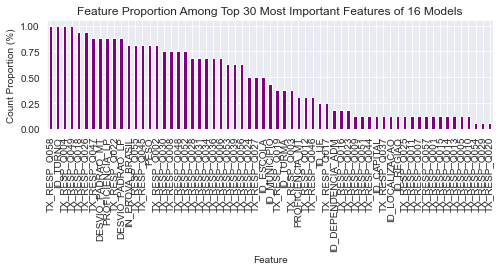

Saved at 2021-08-26 16:26:05.255704


In [800]:
top30_cnt, top_feats = count_top_features(imps_df, n_top=30, plot=True, figsize=(8,2), proportion=True, clear=False,
                                          path='Plots/Feature Importance/Frequency Proportion Barplot - Top 30.png')
print(f'Saved at {datetime.now()}')

# Feature Selection

In [801]:
cnts = top30_cnt.unique(); rank_rows = []

for i, cnt in enumerate(cnts):
    
    rank_rows.append([f'{i+1}°', cnt]+ top30_cnt[top30_cnt==cnt].index.tolist())

feature_rank = pd.DataFrame(rank_rows, 
                            columns=['Rank', 'Count in Top 30', 'Features'] + [ '' for i in range( -3+max([len(row) for row in rank_rows]) )])

feature_rank_head = feature_rank.set_index('Rank').head(12).dropna(how='all', axis=1).replace(np.nan, '')

feature_rank.to_csv('Data/Feature Importance/Feature Rank.csv')
dfi.export(feature_rank_head, 'Tables/Feature Importance/Feature Rank Head.png')
print(f'Saved at {datetime.now()}'); feature_rank_head

Saved at 2021-08-26 16:26:08.706227


,Count in Top 30,Features,,,,
Rank,,,,,,
1°,16,TX_RESP_Q058,ID_TURNO,TX_RESP_Q004,TX_RESP_Q049,
2°,15,TX_RESP_Q018,TX_RESP_Q026,,,
3°,14,TX_RESP_Q047,DESVIO_PADRAO_MT,PROFICIENCIA_LP,TX_RESP_Q022,DESVIO_PADRAO_LP
4°,13,IN_PROVA_BRASIL,TX_RESP_Q055,TX_RESP_Q045,PESO,TX_RESP_Q002
5°,12,TX_RESP_Q030,TX_RESP_Q008,TX_RESP_Q048,TX_RESP_Q052,
6°,11,TX_RESP_Q028,TX_RESP_Q031,TX_RESP_Q034,TX_RESP_Q036,TX_RESP_Q006
7°,10,TX_RESP_Q053,TX_RESP_Q039,TX_RESP_Q056,,
8°,8,TX_RESP_Q024,TX_RESP_Q027,ID_ESCOLA,,
9°,7,ID_MUNICIPIO,,,,


In [802]:
selected_features = np.unique(feature_rank_head.iloc[:4, 1:])[1:]

In [803]:
feats_lst = []
for i in range(4):
    
    feats = feature_rank_head.iloc[i, 1:].replace('', np.nan).dropna()
    
    feats.index = [f'{i+1}°' for j in range(len(feats))]
    
    feats_lst.append(feats)

rank_lst = pd.concat(feats_lst, 0).to_frame()
rank_lst.columns=['Feature']; rank_lst.index.name='Rank'

In [804]:
question_features = [feature for feature in selected_features if feature in dicts[1].index]
remaining_features = [feature for feature in selected_features if feature not in dicts[1].index]

### Identification or Grade Features

In [805]:
remaining_features = rank_lst[[feature not in dicts[1].index for feature in rank_lst['Feature']]].rename(columns={'Feature': 'Identification or Grade Feature'})

In [806]:
dfi.export(remaining_features, 'Tables/Feature Importance/Selected Identification or Grade Features.csv'); remaining_features

,Identification or Grade Feature
Rank,
1°,ID_TURNO
3°,DESVIO_PADRAO_MT
3°,PROFICIENCIA_LP
3°,DESVIO_PADRAO_LP
4°,IN_PROVA_BRASIL
4°,PESO


### Question Features

In [807]:
question_features = rank_lst[[feature in dicts[1].index for feature in rank_lst['Feature']]]['Feature']

In [809]:
Final_Result_Questions = (dicts[1]
               .loc[question_features]
               .dropna(how='all', axis=1)
               .replace(np.nan, '')
              # .head(10)
               )

Final_Result_Questions['Rank'] = question_features.index
Final_Result_Questions = Final_Result_Questions.reset_index().set_index('Rank')

dfi.export(Final_Result_Questions, 'Tables/Feature Importance/Selected Questions.png'); Final_Result_Questions

,questão,Enunciado,A,B,C,D,E,F,G,H
Rank,,,,,,,,,,
1°,TX_RESP_Q058,"Quando você terminar o 9º ano(8ª série), você pretende:",Somente continuar estudando.,Somente Trabalhar.,Continuar estudando e trabalhar.,Ainda não sei.,,,,
1°,TX_RESP_Q004,Em que ano você nasceu?,1999 ou depois.,1998.,1997.,1996.,1995.,1994.,1993.,1992 ou antes.
1°,TX_RESP_Q049,Você já foi reprovado?,Não.,"Sim, uma vez.","Sim, duas vezes ou mais.",,,,,
2°,TX_RESP_Q018,Você mora com sua mãe?,Sim.,Não. (passe para questão 22),"Não, moro com outra mulher responsável por mim.",,,,,
2°,TX_RESP_Q026,Com que frequência seus pais ou responsáveis vão à reunião de pais?,Sempre ou quase sempre.,De vez em quando,Nunca ou quase nunca.,,,,,
3°,TX_RESP_Q047,Quando você entrou na escola?,Na creche (0 a 3 anos).,Na pré-escola (4 a 5 anos).,Na primeira série ou primeiro ano (6 a 7 anos).,Depois da primeira série.,,,,
3°,TX_RESP_Q022,Você mora com seu pai?,Sim.,Não. (passe para questão 26),"Não, moro com outro homem responsável por mim.",,,,,
4°,TX_RESP_Q055,Você faz o dever de casa de matemática?,Sempre ou quase sempre.,De vez em quando.,Nunca ou quase nunca.,,,,,
4°,TX_RESP_Q045,"Em dias de aula, quanto tempo você gasta fazendo trabalhos domésticos?",1 hora ou menos.,2 horas.,3 horas.,4 horas ou mais.,Não faço trabalhos domésticos.,,,


# EXPLANATORY DATA ANALYSIS

### 1/1 sample

In [810]:
train_50, test_50 = binary_sample(qst_filt[[target]+new_features], target, testing=[5000, 5000], training=[1, 1])

Contagem Abandono:


,Original,Treinamento,Teste
Regular,326976,1,5000
Abandono,28217,1,5000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


# Bayesian Probabilities Calculation

In [811]:
dict_9ano = dicts[1].copy()
top_10 = list(rank_lst['Feature'])
top_dict = [question for question in top_10 if question in dict_9ano.index.tolist()]

totals = [test_50[col].value_counts() for col in top_10]
not_rep = [test_50[col][test_50[target]==0].value_counts() for col in top_10]
rep = [test_50[col][test_50[target]==1].value_counts() for col in top_10]

n_class0 = len(test_50[test_50[target]==0])
n_class1 = len(test_50[test_50[target]==1])

not_rep_p = [not_rep[i] / n_class0 for i in range(len(top_10))]
rep_p = [rep[i] / n_class1 for i in range(len(top_10))]


not_rep_props = [not_rep[i]/totals[i] for i in range(len(top_10))]
rep_props = [(rep[i]/totals[i]).loc[not_rep_props[i].index] for i in range(len(top_10))]
#[print([len(i[j]) for j in range(len(top_10))]) for i in [totals, not_rep, rep, not_rep_props, rep_props]]

for name in top_dict:    
    
    i = top_10.index(name)
    
    rep_props[i].index = [dict_9ano.loc[name][index] if index!='.' else 'Sem Resposta' for index in  rep_props[i].index]
    rep_props[i].name = dict_9ano.loc[name]['Enunciado']
    
    not_rep_props[i].index = [dict_9ano.loc[name][index] if index!='.' else 'Sem Resposta' for index in  not_rep_props[i].index]
    not_rep_props[i].name = dict_9ano.loc[name]['Enunciado']
    
    rep_p[i].index = [dict_9ano.loc[name][index] if index!='.' else 'Sem Resposta' for index in  rep_p[i].index]
    rep_p[i].name = dict_9ano.loc[name]['Enunciado']
    
    not_rep_p[i].index = [dict_9ano.loc[name][index] if index!='.' else 'Sem Resposta' for index in  not_rep_p[i].index]
    not_rep_p[i].name = dict_9ano.loc[name]['Enunciado']

### Results

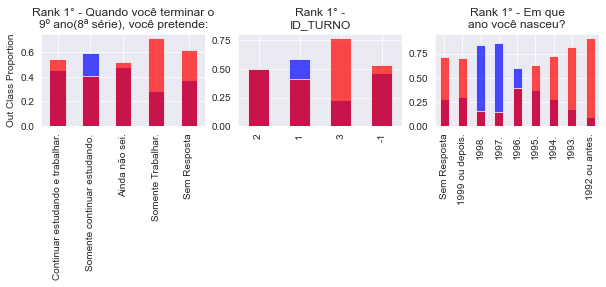

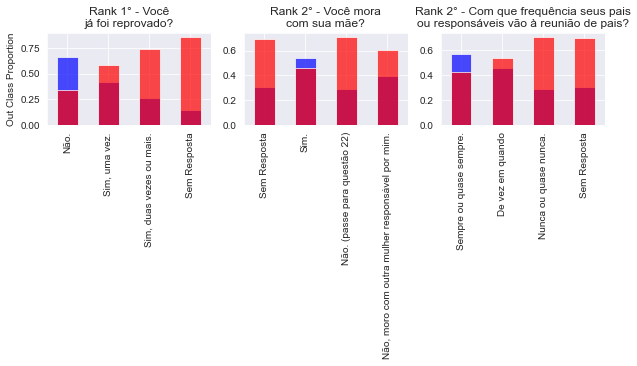

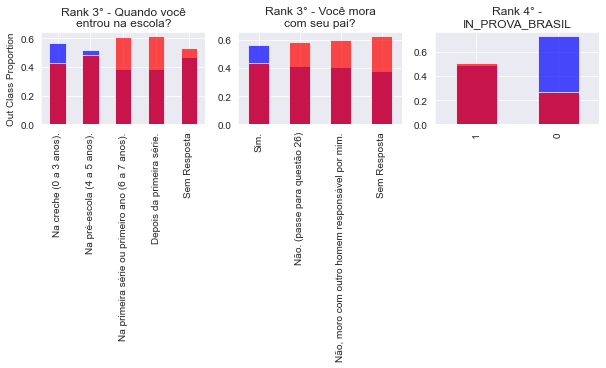

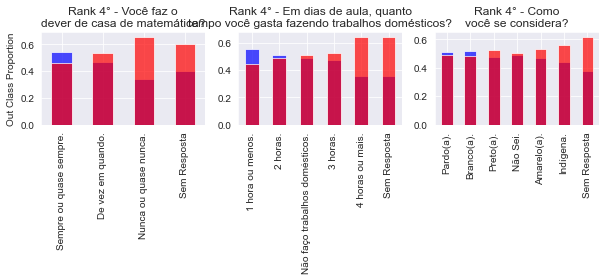

In [855]:
fig = plt.figure(figsize=(10,1.7)); axs = [fig.add_subplot(1,3,i) for i in range(1, 4)]
cnt = 0; stop=False; plt_cnt=0
for i in range(len(rank_lst)):
        
    if len(not_rep_props[i])<25:
        not_rep_props[i].plot.bar(color='blue', ax=axs[cnt], alpha=.7)
        rep_props[i].plot.bar(color='red', ax=axs[cnt], alpha=0.7)
        
        title = (f'Rank {rank_lst.index[i]} - \n'+rep_props[i].name).split()
        lt = int(len(title)/2)+1
        title = ' '.join(title[:lt]) + '\n' + ' '.join(title[lt:])
        axs[cnt].set_title(title)
        if cnt==0: axs[cnt].set_ylabel('Out Class Proportion')
        
        cnt+=1
    if cnt==3:
        cnt=0; plt_cnt+=1
        plt.show()
        plt.pause(0.01)
        
        props_path = f'Plots/Feature Importance/Feature Proportion/Out Class - {plt_cnt}.png'
        fig.savefig(props_path, bbox_inches='tight')

        if i==len(rank_lst)-1: break
        fig = plt.figure(figsize=(10,1.7)); axs = [fig.add_subplot(1,3,i) for i in range(1,4)]

plt.show()
props_path = f'Plots/Feature Importance/Feature Proportion/Out Class - {plt_cnt}.png'
fig.savefig(props_path, bbox_inches='tight')


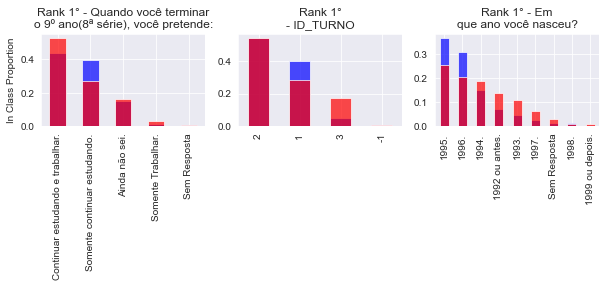

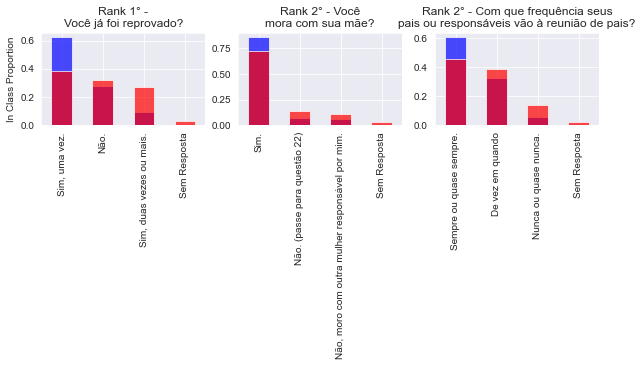

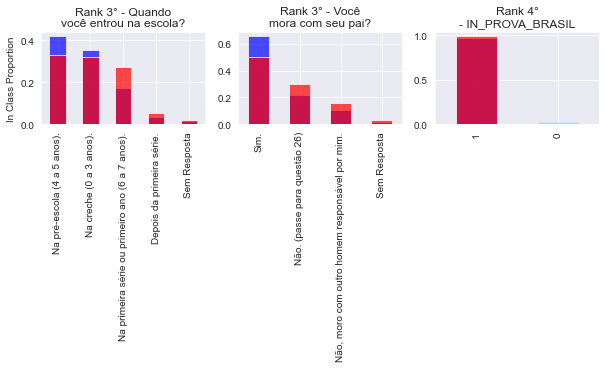

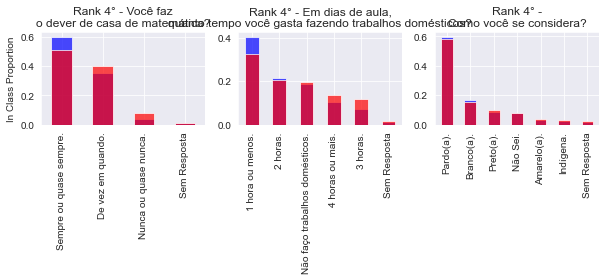

In [856]:
fig = plt.figure(figsize=(10,1.7)); axs = [fig.add_subplot(1,3,i) for i in range(1, 4)]
cnt = 0; stop=False; plt_cnt=0
for i in range(len(top_10)):
        
    if len(not_rep_props[i])<25:
        not_rep_p[i].plot.bar(color='blue', ax=axs[cnt], alpha=.7)
        rep_p[i].plot.bar(color='red', ax=axs[cnt], alpha=.7)
        
        title = (f'Rank {rank_lst.index[i]} - \n'+rep_p[i].name).split()
        lt = int(len(title)/2)
        title = ' '.join(title[:lt]) + '\n' + ' '.join(title[lt:])
        axs[cnt].set_title(title)
        if cnt==0: axs[cnt].set_ylabel('In Class Proportion')
        
        cnt+=1
    if cnt==3:
        cnt=0
        plt_cnt+=1
        plt.show()
        plt.pause(0.01)

        props_path = f'Plots/Feature Importance/Feature Proportion/In Class - {plt_cnt}.png'
        fig.savefig(props_path, bbox_inches='tight')
        
        if i==len(top_10)-1: break
        fig = plt.figure(figsize=(10,1.7)); axs = [fig.add_subplot(1,3,i) for i in range(1,4)]

plt.show()
props_path = f'Plots/Feature Importance/Feature Proportion/In Class - {plt_cnt}.png'
fig.savefig(props_path, bbox_inches='tight')
